In [1]:
import os
import h5py
import json
import random 
import imageio
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.dtypes

Unnamed: 0                                          int64
Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
Unnamed: 0.1                                        int64
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title 

count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


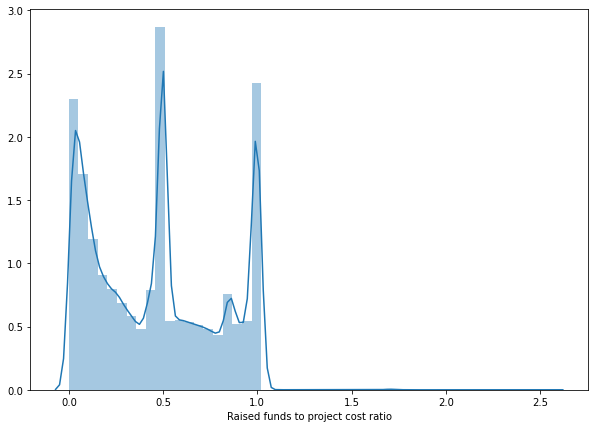

In [5]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


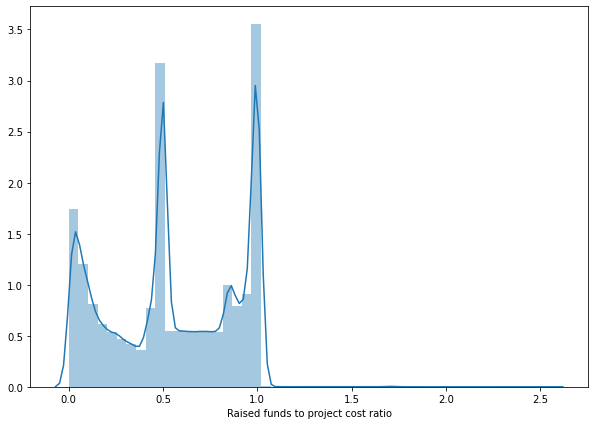

In [6]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [7]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier,hyper_parameters, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    count_itr=0
    
    Overall_Training_Accuracy_GS=[]
    Overall_Training_Precision_GS=[]
    Overall_Training_Recall_GS=[]

    Overall_Testing_Accuracy_GS=[]
    Overall_Testing_Precision_GS=[]
    Overall_Testing_Recall_GS=[]
    
    Overall_Top_K_Accuracy_GS=[]
    Overall_Top_K_Precision_GS=[]
    Overall_Top_K_Recall_GS=[]
    
    Classifier_models=[]
    
    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    
    
    
    #======================================= Grid Search ===========================================
    keys=list(hyper_parameters.keys())
    vals=[]
    
    for i in keys:
        vals+=[hyper_parameters[i]]

    combinations=vals[0]
    for i in range (1,len(vals)):
        combinations = list(itertools.product(combinations,vals[i]))

    for i in range (len (combinations)): #tupples to single list
        try:
            p=list(combinations[i][0])
        except:
            p=[combinations[i][0]]
            
        for j in range (1,len(combinations[i])):
            p+=[combinations[i][j]]
        combinations[i]=p    


    for i in combinations:
        for j in range (len(keys)):
            setattr(Classifier, keys[j],i[j])
        print(Classifier)
        count_itr+=1
        
        
        #=================================== Initiate Time Variables ====================================
    
        print("Initiate Time Variables")
        MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
        MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
        Time_period = timedelta(days=Time_period_indays)  
        T_current = MinT- Time_period +timedelta(days=120) 
        

        #=================================== Loop over time frams =======================================
        
        Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
        Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
        Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()
        
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")


        print(count_itr,"/",len(combinations),"Time iteration is starting\n")
        while (T_current<MaxT-Time_period):

            T_current = T_current+ Time_period
            Time_points+=[T_current]
            T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
            T_Train_end = T_current-Time_period  #End of the data frame
            print("As of Date:",T_current,"\n"+"="*85)

        #====================================== Extract the frams ======================================= 

            # Extracts projects posted before the Current(As of) date
            Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  

            # Extracts projects posted after the start date of the Time window
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]

            #Time period to be consided for the donations since posted (30days, as default)
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]

            #Express the donation amount as a ratio of to the Project cost
            Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]


        #=========================== Do One-Hot_Encoding for Categorical Variables ======================

            for var in Model_variables_cat:
                Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
                Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
                Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
                Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
                #copy the columns to the main data set 
                for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]

            #Add the columns which have not been one-hot-encoded
            for i in Model_variables:
                if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0


        #============================================ Imputing ==========================================
            Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


        #=================================== Training set Creation =====================================

            #extract the training set from the timewindow
            Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
            Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
            Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
            Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]

            # Define Fund_Ratio_Treshold
            Fund_Ratio_Treshold = Fund_Ratio_treshold
            Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()

            # Genarate the Label for the dataset 
            Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                               Fund_Ratio_Treshold  else 0, axis=1)

            X_train = Train_Data_Final.loc[:,Model_variables]
            Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]

            X_train = X_train.loc[:,~X_train.columns.duplicated()]
        #==================================== Testing set Creation =====================================

            #extract the training set from the timewindow
            Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
            Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
            Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
            Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]

            # Genarate the Label for the dataset 
            Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                             Fund_Ratio_Treshold  else 0, axis=1)
            X_test = Test_Data_Final.loc[:,Model_variables]
            Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]

            X_test = X_test.loc[:,~X_test.columns.duplicated()]
        #===================================== Model Training =========================================
            
            Classifier.fit(X_train, Y_train)

            # Predict on training 
            Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
            Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
            # Predict on testing 
            Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
            Test_Data_Final["Y_pred"] = Classifier.predict(X_test)


        #====================================== Evaluation Trainign  ============================================

            Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
            Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()

            Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
            Training_Precision=Training_TP/(Training_TP+Training_FP)
            Training_Recall=Training_TP/(Training_TP+Training_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Training_Accuracy)
            print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
                  "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)


        #====================================== Evaluation Testign  ============================================   

            Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
            Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()

            Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
            Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
            Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
            print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
                  "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)

        #====================================== Evaluation Top K  ============================================        

            Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
            Top_K=Test_Data_Final.head(K)
            Y_test_Top_K =  Top_K.loc[:,["Label"]] 
            Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
            Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
            if len(Testing_Top_K_CM.ravel())==4:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
            else:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K

            Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                        + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
            Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FP)
            Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Top_K_Accuracy)
            print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
                  "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)

         #====================================== save computed values  ============================================       
            Output["Overall_Training_Accuracy"] += [Training_Accuracy]
            Output["Overall_Training_Precision"] += [Training_Precision]
            Output["Overall_Training_Recall"] += [Training_Recall ]

            Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
            Output["Overall_Testing_Precision"] += [Testing_Precision]
            Output["Overall_Testing_Recall"] += [Testing_Recall]

            Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
            Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
            Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
            
            
        Overall_Training_Accuracy_GS+=[sum(Output["Overall_Training_Accuracy"])/len(Output["Overall_Training_Accuracy"])]
        Overall_Training_Precision_GS+=[sum(Output["Overall_Training_Precision"])/len(Output["Overall_Training_Precision"])]
        Overall_Training_Recall_GS+=[sum(Output["Overall_Training_Recall"])/len(Output["Overall_Training_Recall"])]

        Overall_Testing_Accuracy_GS+=[sum(Output["Overall_Testing_Accuracy"])/len(Output["Overall_Testing_Accuracy"])]
        Overall_Testing_Precision_GS+=[sum(Output["Overall_Testing_Precision"])/len(Output["Overall_Testing_Precision"])]
        Overall_Testing_Recall_GS+=[sum(Output["Overall_Testing_Recall"])/len(Output["Overall_Testing_Recall"])]

        Overall_Top_K_Accuracy_GS+=[sum(Output["Top_K_Accuracy"])/len(Output["Top_K_Accuracy"])]
        Overall_Top_K_Precision_GS+=[sum(Output["Top_K_Precision"])/len(Output["Top_K_Precision"])]
        Overall_Top_K_Recall_GS+=[sum(Output["Top_K_Recall"])/len(Output["Top_K_Recall"])]
        
        Classifier_models+=[Classifier]
        
    
    
    Output["Overall_Training_Accuracy"] = Overall_Training_Accuracy_GS
    Output["Overall_Training_Precision"] =Overall_Training_Precision_GS
    Output["Overall_Training_Recall"] =Overall_Training_Precision_GS

    Output["Overall_Testing_Accuracy"] =Overall_Testing_Accuracy_GS
    Output["Overall_Testing_Precision"] =Overall_Testing_Precision_GS
    Output["Overall_Testing_Recall"] =Overall_Testing_Recall_GS

    Output["Top_K_Accuracy"] = Overall_Top_K_Accuracy_GS
    Output["Top_K_Precision"] = Overall_Top_K_Precision_GS
    Output["Top_K_Recall"] = Overall_Top_K_Recall_GS
    
    Output["Classifier"]=Classifier_models
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    
    print(Overall_Training_Accuracy_GS)
    return Output,Test_Data_Final,Train_Data_Final
        

In [8]:
import xgboost as xgb

clf = xgb.XGBClassifier(random_state=1,learning_rate=0.01)

hyper_para=dict()
hyper_para["eta"]=[1,0.3,0.03]
hyper_para["max_depth"]=[5,21,35,50]
hyper_para["min_child_weight"]=[5,10,20,30]
# hyper_para["criterion"]=["gini", "entropy"]

Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, hyper_para,Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.03)

Initiatnig the Columns
Variables considered in model training
> Number of dates since posted True
> Project ID True
> Donation Amount True
> Project Cost True
> Project Posted Date True
> Project Expiration Date True
> Donation Received Date True

One-Hot-Encoding removing columns identification
XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=5,
              random_state=1)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1 / 48 Time iteration is starting

As of Date: 2013-05-01 00:00:00 
XGBClassifier  Testing Accuracy =  0.6537374775237605
	Training_TP: 5198 	Training_FP: 2804 
	Training_TN: 4982 	Training_FN: 2588

XGBClassifier  Testing Accuracy =  0.6242100145843461
	Testing_TP: 1192 	Testing_FP: 826 
	Testing_TN: 1376 	Testing_FN: 720

XGBClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
XGBCl

XGBClassifier  Testing Accuracy =  0.6478519497686716
	Training_TP: 4601 	Training_FP: 2364 
	Training_TN: 5201 	Training_FN: 2964

XGBClassifier  Testing Accuracy =  0.6265536723163841
	Testing_TP: 1727 	Testing_FP: 922 
	Testing_TN: 1600 	Testing_FN: 1061

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.6416291986247025
	Training_TP: 5135 	Training_FP: 2993 
	Training_TN: 4569 	Training_FN: 2427

XGBClassifier  Testing Accuracy =  0.5767580287929125
	Testing_TP: 3868 	Testing_FP: 3223 
	Testing_TN: 4465 	Testing_FN: 2892

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.6343505154639175
	Training_TP: 7406 	Training_FP: 4148 
	Training_TN: 7977 	Training_FN: 4719

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6559247080167819
	Training_TP: 14616 	Training_FP: 7741 
	Training_TN: 14307 	Training_FN: 7431

XGBClassifier  Testing Accuracy =  0.6245213549337261
	Testing_TP: 4234 	Testing_FP: 2766 
	Testing_TN: 4247 	Testing_FN: 2333

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.6504343536762489
	Training_TP: 12189 	Training_FP: 6700 
	Training_TN: 11546 	Training_FN: 6056

XGBClassifier  Testing Accuracy =  0.6393593731996774
	Testing_TP: 2512 	Testing_FP: 1598 
	Testing_TN: 3037 	Testing_FN: 1532

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6490380117870841
	Training_TP: 9899 	Training_FP: 5120 
	Training_TN: 10915 	Training_FN: 6135

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6412804298983161
	Training_TP: 13053 	Training_FP: 7149 
	Training_TN: 14633 	Training_FN: 8338

XGBClassifier  Testing Accuracy =  0.6250512925728354
	Testing_TP: 2800 	Testing_FP: 1635 
	Testing_TN: 3293 	Testing_FN: 2020

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.6335437088760575
	Training_TP: 10864 	Training_FP: 6158 
	Training_TN: 12726 	Training_FN: 7487

XGBClassifier  Testing Accuracy =  0.6194198957625199
	Testing_TP: 3178 	Testing_FP: 1100 
	Testing_TN: 2289 	Testing_FN: 2259

XGBClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.6367035411902849
	Training_TP: 9668 	Training_FP: 5244 
	Training_TN: 10937 	Training_FN: 6513

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6418315252074027
	Training_TP: 4506 	Training_FP: 2728 
	Training_TN: 3540 	Training_FN: 1762

XGBClassifier  Testing Accuracy =  0.6195482460705736
	Testing_TP: 3018 	Testing_FP: 2528 
	Testing_TN: 2934 	Testing_FN: 1127

XGBClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.6484586861475455
	Training_TP: 6154 	Training_FP: 3472 
	Training_TN: 5563 	Training_FN: 2880

XGBClassifier  Testing Accuracy =  0.6328976877271673
	Testing_TP: 4958 	Testing_FP: 2113 
	Testing_TN: 3226 	Testing_FN: 2634

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.650955507464329
	Training_TP: 9217 	Training_FP: 5102 
	Training_TN: 8530 	Training_FN: 4414

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6463723439392272
	Training_TP: 9198 	Training_FP: 5210 
	Training_TN: 8415 	Training_FN: 4426

XGBClassifier  Testing Accuracy =  0.6263620848102928
	Testing_TP: 1858 	Testing_FP: 1543 
	Testing_TN: 2913 	Testing_FN: 1303

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.6450333979745745
	Training_TP: 8226 	Training_FP: 4861 
	Training_TN: 6742 	Training_FN: 3376

XGBClassifier  Testing Accuracy =  0.6410440122824974
	Testing_TP: 3165 	Testing_FP: 1933 
	Testing_TN: 3098 	Testing_FN: 1574

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6432665338807365
	Training_TP: 8679 	Training_FP: 5155 
	Training_TN: 7146 	Training_FN: 3621

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.6390070306397014
	Training_TP: 11229 	Training_FP: 6425 
	Training_TN: 10857 	Training_FN: 6052

XGBClassifier  Testing Accuracy =  0.6471010332950632
	Testing_TP: 2823 	Testing_FP: 1074 
	Testing_TN: 1686 	Testing_FN: 1385

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.6479915830609101
	Training_TP: 8648 	Training_FP: 4710 
	Training_TN: 8597 	Training_FN: 4658

XGBClassifier  Testing Accuracy =  0.6333774834437086
	Testing_TP: 2592 	Testing_FP: 1389 
	Testing_TN: 2190 	Testing_FN: 1379

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
XGBClassifier  Testing Accuracy =  0.6421672132620513
	Training_TP: 7102 	Training_FP: 3938 
	Training_TN: 7192 	Training_FN: 4027

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.6318407214873185
	Training_TP: 20120 	Training_FP: 11320 
	Training_TN: 22056 	Training_FN: 13255

XGBClassifier  Testing Accuracy =  0.6220242829118287
	Testing_TP: 5518 	Testing_FP: 2987 
	Testing_TN: 6214 	Testing_FN: 4142

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.6354983629026117
	Training_TP: 19725 	Training_FP: 10828 
	Training_TN: 22005 	Training_FN: 13107

XGBClassifier  Testing Accuracy =  0.6250502960280508
	Testing_TP: 5451 	Testing_FP: 3207 
	Testing_TN: 5423 	Testing_FN: 3316

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.6303506714053118
	Training_TP: 17304 	Training_FP: 9859 
	Training_TN: 18701 	Training_FN: 11255

XGBClassifier  T

XGBClassifier  Testing Accuracy =  0.6635295119666127
	Training_TP: 7373 	Training_FP: 3533 
	Training_TN: 8208 	Training_FN: 4368

XGBClassifier  Testing Accuracy =  0.6175103305785123
	Testing_TP: 1865 	Testing_FP: 1428 
	Testing_TN: 2917 	Testing_FN: 1534

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6409676798768758
	Training_TP: 6881 	Training_FP: 3950 
	Training_TN: 6446 	Training_FN: 3515

XGBClassifier  Testing Accuracy =  0.6180333688320909
	Testing_TP: 2736 	Testing_FP: 1668 
	Testing_TN: 2487 	Testing_FN: 1560

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.6433181387371937
	Training_TP: 6838 	Training_FP: 3663 
	Training_TN: 7416 	Training_FN: 4240

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6709079747753781
	Training_TP: 6042 	Training_FP: 2980 
	Training_TN: 5980 	Training_FN: 2917

XGBClassifier  Testing Accuracy =  0.6283470907992752
	Testing_TP: 1530 	Testing_FP: 965 
	Testing_TN: 1591 	Testing_FN: 881

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.6545098287086784
	Training_TP: 5270 	Training_FP: 2826 
	Training_TN: 5085 	Training_FN: 2640

XGBClassifier  Testing Accuracy =  0.6202359346642469
	Testing_TP: 2893 	Testing_FP: 2789 
	Testing_TN: 3942 	Testing_FN: 1396

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.6427462237071196
	Training_TP: 7176 	Training_FP: 4143 
	Training_TN: 6483 	Training_FN: 3449

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.6616415083286141
	Training_TP: 17474 	Training_FP: 9197 
	Training_TN: 16408 	Training_FN: 8130

XGBClassifier  Testing Accuracy =  0.6479176478503667
	Testing_TP: 4178 	Testing_FP: 2894 
	Testing_TN: 5452 	Testing_FN: 2339

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6547442366676561
	Training_TP: 13772 	Training_FP: 7516 
	Training_TN: 12698 	Training_FN: 6442

XGBClassifier  Testing Accuracy =  0.6534286231228514
	Testing_TP: 2942 	Testing_FP: 2127 
	Testing_TN: 4281 	Testing_FN: 1704

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.652561492323777
	Training_TP: 12607 	Training_FP: 7062 
	Training_TN: 11111 	Training_FN: 5566

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6476367839712304
	Training_TP: 5108 	Training_FP: 2809 
	Training_TN: 4977 	Training_FN: 2678

XGBClassifier  Testing Accuracy =  0.6261545940690326
	Testing_TP: 1194 	Testing_FP: 820 
	Testing_TN: 1382 	Testing_FN: 718

XGBClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
XGBClassifier  Testing Accuracy =  0.6487384698860553
	Training_TP: 4906 	Training_FP: 2713 
	Training_TN: 4659 	Training_FN: 2466

XGBClassifier  Testing Accuracy =  0.6167518870221573
	Testing_TP: 1384 	Testing_FP: 831 
	Testing_TN: 1149 	Testing_FN: 743

XGBClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6547332453211152
	Training_TP: 4388 	Training_FP: 2396 
	Training_TN: 4043 	Training_FN: 2050

XGBClassifier  Testing Accurac

XGBClassifier  Testing Accuracy =  0.6308453608247423
	Training_TP: 7416 	Training_FP: 4243 
	Training_TN: 7882 	Training_FN: 4709

XGBClassifier  Testing Accuracy =  0.664655348742074
	Testing_TP: 7979 	Testing_FP: 2839 
	Testing_TN: 5019 	Testing_FN: 3719

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.6544912316476346
	Training_TP: 12162 	Training_FP: 6101 
	Training_TN: 13515 	Training_FN: 7454

XGBClassifier  Testing Accuracy =  0.6322431109966521
	Testing_TP: 4119 	Testing_FP: 1743 
	Testing_TN: 3246 	Testing_FN: 2541

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6592742824390458
	Training_TP: 14695 	Training_FP: 7470 
	Training_TN: 15211 	Training_FN: 7986

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6486326358788862
	Training_TP: 9914 	Training_FP: 5148 
	Training_TN: 10887 	Training_FN: 6120

XGBClassifier  Testing Accuracy =  0.6343164439963028
	Testing_TP: 3340 	Testing_FP: 1992 
	Testing_TN: 4209 	Testing_FN: 2360

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.6422865258299307
	Training_TP: 11125 	Training_FP: 6316 
	Training_TN: 10583 	Training_FN: 5774

XGBClassifier  Testing Accuracy =  0.6249589490968801
	Testing_TP: 4284 	Testing_FP: 3013 
	Testing_TN: 5231 	Testing_FN: 2697

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6322344322344322
	Training_TP: 10783 	Training_FP: 6090 
	Training_TN: 11655 	Training_FN: 6962

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6359310302206291
	Training_TP: 9700 	Training_FP: 5301 
	Training_TN: 10880 	Training_FN: 6481

XGBClassifier  Testing Accuracy =  0.6183954844082539
	Testing_TP: 3822 	Testing_FP: 1754 
	Testing_TN: 2861 	Testing_FN: 2370

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
XGBClassifier  Testing Accuracy =  0.6442025228961465
	Training_TP: 9375 	Training_FP: 5203 
	Training_TN: 9265 	Training_FN: 5092

XGBClassifier  Testing Accuracy =  0.6250389125246446
	Testing_TP: 5414 	Testing_FP: 4104 
	Testing_TN: 6633 	Testing_FN: 3123

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.633381660021747
	Training_TP: 12509 	Training_FP: 7357 
	Training_TN: 11956 	Training_FN: 6804

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.8540145985401459
	Training_TP: 11706 	Training_FP: 2055 
	Training_TN: 11577 	Training_FN: 1925

XGBClassifier  Testing Accuracy =  0.6179797003383277
	Testing_TP: 3350 	Testing_FP: 1942 
	Testing_TN: 3043 	Testing_FN: 2010

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.8500670568154108
	Training_TP: 14025 	Training_FP: 2540 
	Training_TN: 13864 	Training_FN: 2379

XGBClassifier  Testing Accuracy =  0.6453443632166218
	Testing_TP: 3712 	Testing_FP: 2009 
	Testing_TN: 2997 	Testing_FN: 1678

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.8530683319322685
	Training_TP: 14080 	Training_FP: 2320 
	Training_TN: 14334 	Training_FN: 2574

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.8592740132514939
	Training_TP: 10571 	Training_FP: 1733 
	Training_TN: 10568 	Training_FN: 1729

XGBClassifier  Testing Accuracy =  0.6479418318283101
	Testing_TP: 3278 	Testing_FP: 1448 
	Testing_TN: 2247 	Testing_FN: 1554

XGBClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.8599048881266079
	Training_TP: 10827 	Training_FP: 1594 
	Training_TN: 11233 	Training_FN: 2000

XGBClassifier  Testing Accuracy =  0.6379310344827587
	Testing_TP: 2217 	Testing_FP: 1284 
	Testing_TN: 2445 	Testing_FN: 1362

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.851850396794217
	Training_TP: 10602 	Training_FP: 1646 
	Training_TN: 11081 	Training_FN: 2125

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8518352127229435
	Training_TP: 9469 	Training_FP: 1638 
	Training_TN: 9492 	Training_FN: 1660

XGBClassifier  Testing Accuracy =  0.6263599977450814
	Testing_TP: 5674 	Testing_FP: 3708 
	Testing_TN: 5437 	Testing_FN: 2920

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.8511328880843892
	Training_TP: 13548 	Training_FP: 2297 
	Training_TN: 13724 	Training_FN: 2473

XGBClassifier  Testing Accuracy =  0.6459251312310816
	Testing_TP: 8618 	Testing_FP: 4869 
	Testing_TN: 8240 	Testing_FN: 4372

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.8516518983627721
	Training_TP: 21638 	Training_FP: 3661 
	Training_TN: 21901 	Training_FN: 3923

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8599065109683293
	Training_TP: 24567 	Training_FP: 4010 
	Training_TN: 24550 	Training_FN: 3992

XGBClassifier  Testing Accuracy =  0.6231205137891953
	Testing_TP: 3477 	Testing_FP: 2867 
	Testing_TN: 4770 	Testing_FN: 2121

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
XGBClassifier  Testing Accuracy =  0.8573152276166714
	Training_TP: 20937 	Training_FP: 3465 
	Training_TN: 20984 	Training_FN: 3512

XGBClassifier  Testing Accuracy =  0.6124038237351364
	Testing_TP: 5708 	Testing_FP: 4121 
	Testing_TN: 7425 	Testing_FN: 4191

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.857303392556139
	Training_TP: 22031 	Training_FP: 3590 
	Training_TN: 22217 	Training_FN: 3775

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7634607573227422
	Training_TP: 8518 	Training_FP: 2681 
	Training_TN: 8398 	Training_FN: 2560

XGBClassifier  Testing Accuracy =  0.6196573489630297
	Testing_TP: 1716 	Testing_FP: 1152 
	Testing_TN: 1720 	Testing_FN: 957

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.7585192792456353
	Training_TP: 8161 	Training_FP: 2623 
	Training_TN: 8088 	Training_FN: 2550

XGBClassifier  Testing Accuracy =  0.6008713771547641
	Testing_TP: 1705 	Testing_FP: 1074 
	Testing_TN: 1467 	Testing_FN: 1033

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.7665410385259631
	Training_TP: 7332 	Training_FP: 2240 
	Training_TN: 7312 	Training_FN: 2220

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.7623641240412216
	Training_TP: 8202 	Training_FP: 2627 
	Training_TN: 7999 	Training_FN: 2423

XGBClassifier  Testing Accuracy =  0.6360586424008456
	Testing_TP: 7140 	Testing_FP: 4010 
	Testing_TN: 6700 	Testing_FN: 3909

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.7624435590969455
	Training_TP: 14281 	Training_FP: 4400 
	Training_TN: 14425 	Training_FN: 4544

XGBClassifier  Testing Accuracy =  0.6363135092556125
	Testing_TP: 4096 	Testing_FP: 2074 
	Testing_TN: 3982 	Testing_FN: 2543

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.7674197961255019
	Training_TP: 17428 	Training_FP: 5308 
	Training_TN: 17353 	Training_FN: 5233

XGBClassifier  Testing A

XGBClassifier  Testing Accuracy =  0.7730424255764046
	Training_TP: 14257 	Training_FP: 4333 
	Training_TN: 13840 	Training_FN: 3916

XGBClassifier  Testing Accuracy =  0.6343040040165684
	Testing_TP: 4894 	Testing_FP: 3228 
	Testing_TN: 5213 	Testing_FN: 2599

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7699377623389781
	Training_TP: 16114 	Training_FP: 4924 
	Training_TN: 15803 	Training_FN: 4613

XGBClassifier  Testing Accuracy =  0.63334827431645
	Testing_TP: 3726 	Testing_FP: 2771 
	Testing_TN: 4752 	Testing_FN: 2137

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7698195053849222
	Training_TP: 15494 	Training_FP: 4671 
	Training_TN: 15385 	Training_FN: 4562

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7069316332067281
	Training_TP: 5314 	Training_FP: 2263 
	Training_TN: 5109 	Training_FN: 2058

XGBClassifier  Testing Accuracy =  0.6172388604821037
	Testing_TP: 1334 	Testing_FP: 779 
	Testing_TN: 1201 	Testing_FN: 793

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.7081618389376407
	Training_TP: 4621 	Training_FP: 1941 
	Training_TN: 4498 	Training_FN: 1817

XGBClassifier  Testing Accuracy =  0.6171997902464604
	Testing_TP: 1588 	Testing_FP: 600 
	Testing_TN: 766 	Testing_FN: 860

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6979731420468763
	Training_TP: 4429 	Training_FP: 2056 
	Training_TN: 3939 	Training_FN: 1565

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.7090895187601958
	Training_TP: 13584 	Training_FP: 5381 
	Training_TN: 14235 	Training_FN: 6032

XGBClassifier  Testing Accuracy =  0.6367070134775518
	Testing_TP: 4246 	Testing_FP: 1818 
	Testing_TN: 3171 	Testing_FN: 2414

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.7099113795688021
	Training_TP: 15745 	Training_FP: 6223 
	Training_TN: 16458 	Training_FN: 6936

XGBClassifier  Testing Accuracy =  0.6270308453025665
	Testing_TP: 2636 	Testing_FP: 1690 
	Testing_TN: 2690 	Testing_FN: 1478

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.7161224925309433
	Training_TP: 13350 	Training_FP: 5248 
	Training_TN: 13496 	Training_FN: 5394

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.7072016095626961
	Training_TP: 12061 	Training_FP: 5058 
	Training_TN: 11841 	Training_FN: 4838

XGBClassifier  Testing Accuracy =  0.6164203612479474
	Testing_TP: 4218 	Testing_FP: 3077 
	Testing_TN: 5167 	Testing_FN: 2763

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.7012679628064243
	Training_TP: 11959 	Training_FP: 4816 
	Training_TN: 12929 	Training_FN: 5786

XGBClassifier  Testing Accuracy =  0.6196933962264151
	Testing_TP: 3687 	Testing_FP: 2136 
	Testing_TN: 3670 	Testing_FN: 2379

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.7012879317940346
	Training_TP: 13286 	Training_FP: 5519 
	Training_TN: 13776 	Training_FN: 6008

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.7036806635562468
	Training_TP: 10128 	Training_FP: 4235 
	Training_TN: 10233 	Training_FN: 4339

XGBClassifier  Testing Accuracy =  0.6180865414548096
	Testing_TP: 5271 	Testing_FP: 4095 
	Testing_TN: 6642 	Testing_FN: 3266

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.7003054937089007
	Training_TP: 13414 	Training_FP: 5677 
	Training_TN: 13636 	Training_FN: 5899

XGBClassifier  Testing Accuracy =  0.627909621654409
	Testing_TP: 7989 	Testing_FP: 5114 
	Testing_TN: 8574 	Testing_FN: 4701

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.7016289657134728
	Training_TP: 19394 	Training_FP: 8056 
	Training_TN: 20060 	Training_FN: 8722

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.689039258717386
	Training_TP: 11424 	Training_FP: 5222 
	Training_TN: 11182 	Training_FN: 4980

XGBClassifier  Testing Accuracy =  0.6522701038861101
	Testing_TP: 3663 	Testing_FP: 1888 
	Testing_TN: 3118 	Testing_FN: 1727

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6955986549777832
	Training_TP: 11560 	Training_FP: 5045 
	Training_TN: 11609 	Training_FN: 5094

XGBClassifier  Testing Accuracy =  0.6550948699929726
	Testing_TP: 1666 	Testing_FP: 1573 
	Testing_TN: 2995 	Testing_FN: 881

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.6979109701410915
	Training_TP: 9446 	Training_FP: 4018 
	Training_TN: 9697 	Training_FN: 4268

XGBClassifier  Testing A

XGBClassifier  Testing Accuracy =  0.7027364153738208
	Training_TP: 8969 	Training_FP: 3768 
	Training_TN: 9059 	Training_FN: 3858

XGBClassifier  Testing Accuracy =  0.6602353585112206
	Testing_TP: 2380 	Testing_FP: 1284 
	Testing_TN: 2445 	Testing_FN: 1199

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7129331342814489
	Training_TP: 8774 	Training_FP: 3354 
	Training_TN: 9373 	Training_FN: 3953

XGBClassifier  Testing Accuracy =  0.6428317324795446
	Testing_TP: 1700 	Testing_FP: 855 
	Testing_TN: 1914 	Testing_FN: 1153

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7073090171282971
	Training_TP: 7386 	Training_FP: 2993 
	Training_TN: 7604 	Training_FN: 3210

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.6976156294862992
	Training_TP: 11126 	Training_FP: 4794 
	Training_TN: 11227 	Training_FN: 4895

XGBClassifier  Testing Accuracy =  0.6600636039695007
	Testing_TP: 8874 	Testing_FP: 4756 
	Testing_TN: 8353 	Testing_FN: 4116

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.7029712653795748
	Training_TP: 17842 	Training_FP: 7466 
	Training_TN: 18096 	Training_FN: 7719

XGBClassifier  Testing Accuracy =  0.6435539841550448
	Testing_TP: 4935 	Testing_FP: 2528 
	Testing_TN: 4894 	Testing_FN: 2916

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7060223351634343
	Training_TP: 20883 	Training_FP: 8763 
	Training_TN: 20653 	Training_FN: 8532

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6833408319358665
	Training_TP: 16524 	Training_FP: 7559 
	Training_TN: 16890 	Training_FN: 7925

XGBClassifier  Testing Accuracy =  0.6245278619724878
	Testing_TP: 5758 	Testing_FP: 3911 
	Testing_TN: 7635 	Testing_FN: 4141

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.674054986146901
	Training_TP: 17128 	Training_FP: 8145 
	Training_TN: 17662 	Training_FN: 8678

XGBClassifier  Testing Accuracy =  0.616162296960302
	Testing_TP: 4050 	Testing_FP: 2675 
	Testing_TN: 5092 	Testing_FN: 3020

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.6771353697485873
	Training_TP: 16073 	Training_FP: 7594 
	Training_TN: 17001 	Training_FN: 8176

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8494538325086359
	Training_TP: 9125 	Training_FP: 1639 
	Training_TN: 9072 	Training_FN: 1586

XGBClassifier  Testing Accuracy =  0.5974616404622087
	Testing_TP: 1674 	Testing_FP: 1061 
	Testing_TN: 1480 	Testing_FN: 1064

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.8549518425460636
	Training_TP: 8174 	Training_FP: 1393 
	Training_TN: 8159 	Training_FN: 1378

XGBClassifier  Testing Accuracy =  0.5982258762440502
	Testing_TP: 1585 	Testing_FP: 844 
	Testing_TN: 1180 	Testing_FN: 1013

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.8506278916060807
	Training_TP: 6446 	Training_FP: 1141 
	Training_TN: 6424 	Training_FN: 1119

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.8518193891102258
	Training_TP: 16007 	Training_FP: 2761 
	Training_TN: 16064 	Training_FN: 2818

XGBClassifier  Testing Accuracy =  0.6281213076014179
	Testing_TP: 4046 	Testing_FP: 2128 
	Testing_TN: 3928 	Testing_FN: 2593

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.8513746083579719
	Training_TP: 19340 	Training_FP: 3415 
	Training_TN: 19246 	Training_FN: 3321

XGBClassifier  Testing Accuracy =  0.6324308700260141
	Testing_TP: 3267 	Testing_FP: 1964 
	Testing_TN: 3297 	Testing_FN: 1851

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.8473069509014628
	Training_TP: 18745 	Training_FP: 3431 
	Training_TN: 18617 	Training_FN: 3302

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.8534761422299416
	Training_TP: 17761 	Training_FP: 3108 
	Training_TN: 17619 	Training_FN: 2966

XGBClassifier  Testing Accuracy =  0.6290900941281936
	Testing_TP: 3731 	Testing_FP: 2833 
	Testing_TN: 4690 	Testing_FN: 2132

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.8545821699242122
	Training_TP: 17174 	Training_FP: 2951 
	Training_TN: 17105 	Training_FN: 2882

XGBClassifier  Testing Accuracy =  0.602832469775475
	Testing_TP: 3979 	Testing_FP: 2477 
	Testing_TN: 4747 	Testing_FN: 3272

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.8588701271628101
	Training_TP: 18204 	Training_FP: 2906 
	Training_TN: 18876 	Training_FN: 3187

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7620563795915197
	Training_TP: 4970 	Training_FP: 1596 
	Training_TN: 4843 	Training_FN: 1468

XGBClassifier  Testing Accuracy =  0.6151022548505506
	Testing_TP: 1584 	Testing_FP: 604 
	Testing_TN: 762 	Testing_FN: 864

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.7616148135791142
	Training_TP: 4704 	Training_FP: 1568 
	Training_TN: 4427 	Training_FN: 1290

XGBClassifier  Testing Accuracy =  0.591927303465765
	Testing_TP: 1412 	Testing_FP: 1151 
	Testing_TN: 1389 	Testing_FN: 780

XGBClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
XGBClassifier  Testing Accuracy =  0.7568602425015954
	Training_TP: 4802 	Training_FP: 1582 
	Training_TN: 4686 	Training_FN: 1466

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.762752965036815
	Training_TP: 16991 	Training_FP: 5072 
	Training_TN: 17609 	Training_FN: 5690

XGBClassifier  Testing Accuracy =  0.6202024958794443
	Testing_TP: 2590 	Testing_FP: 1702 
	Testing_TN: 2678 	Testing_FN: 1524

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.7663252240717029
	Training_TP: 14308 	Training_FP: 4324 
	Training_TN: 14420 	Training_FN: 4436

XGBClassifier  Testing Accuracy =  0.6291772916387062
	Testing_TP: 1748 	Testing_FP: 1683 
	Testing_TN: 2940 	Testing_FN: 1080

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7721384270982421
	Training_TP: 10588 	Training_FP: 3173 
	Training_TN: 10452 	Training_FN: 3036

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7651732882502114
	Training_TP: 13224 	Training_FP: 3813 
	Training_TN: 13932 	Training_FN: 4521

XGBClassifier  Testing Accuracy =  0.6127863881401617
	Testing_TP: 3655 	Testing_FP: 2186 
	Testing_TN: 3620 	Testing_FN: 2411

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.764622042550986
	Training_TP: 14530 	Training_FP: 4319 
	Training_TN: 14976 	Training_FN: 4764

XGBClassifier  Testing Accuracy =  0.6154039136979428
	Testing_TP: 2640 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1565

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.7705349651361282
	Training_TP: 13250 	Training_FP: 3900 
	Training_TN: 13382 	Training_FN: 4031

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7660384197172889
	Training_TP: 14625 	Training_FP: 4349 
	Training_TN: 14964 	Training_FN: 4688

XGBClassifier  Testing Accuracy =  0.6240048525286224
	Testing_TP: 7953 	Testing_FP: 5181 
	Testing_TN: 8507 	Testing_FN: 4737

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.7660051216389244
	Training_TP: 21163 	Training_FP: 6205 
	Training_TN: 21911 	Training_FN: 6953

XGBClassifier  Testing Accuracy =  0.609346493895308
	Testing_TP: 6640 	Testing_FP: 3769 
	Testing_TN: 6386 	Testing_FN: 4582

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.7741307246333389
	Training_TP: 25336 	Training_FP: 7038 
	Training_TN: 26338 	Training_FN: 8039

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7152035547015732
	Training_TP: 11860 	Training_FP: 4692 
	Training_TN: 11962 	Training_FN: 4794

XGBClassifier  Testing Accuracy =  0.652986647926915
	Testing_TP: 1655 	Testing_FP: 1577 
	Testing_TN: 2991 	Testing_FN: 892

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.7154471544715447
	Training_TP: 9708 	Training_FP: 3799 
	Training_TN: 9916 	Training_FN: 4006

XGBClassifier  Testing Accuracy =  0.632234076947947
	Testing_TP: 1641 	Testing_FP: 1064 
	Testing_TN: 2270 	Testing_FN: 1211

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.7213184566902309
	Training_TP: 8198 	Training_FP: 3001 
	Training_TN: 8740 	Training_FN: 3543

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.7311228097744952
	Training_TP: 9038 	Training_FP: 3155 
	Training_TN: 9572 	Training_FN: 3689

XGBClassifier  Testing Accuracy =  0.6422981145499822
	Testing_TP: 1685 	Testing_FP: 843 
	Testing_TN: 1926 	Testing_FN: 1168

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7277874769971217
	Training_TP: 7625 	Training_FP: 2798 
	Training_TN: 7799 	Training_FN: 2971

XGBClassifier  Testing Accuracy =  0.6307292633141585
	Testing_TP: 1928 	Testing_FP: 821 
	Testing_TN: 1471 	Testing_FN: 1169

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7177297840281266
	Training_TP: 6492 	Training_FP: 2591 
	Training_TN: 6369 	Training_FN: 2467

XGBClassifier  Testing Accura

XGBClassifier  Testing Accuracy =  0.7249378948809734
	Training_TP: 18447 	Training_FP: 6948 
	Training_TN: 18614 	Training_FN: 7114

XGBClassifier  Testing Accuracy =  0.6426373338571335
	Testing_TP: 4952 	Testing_FP: 2559 
	Testing_TN: 4863 	Testing_FN: 2899

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7256208461525386
	Training_TP: 21431 	Training_FP: 8158 
	Training_TN: 21258 	Training_FN: 7984

XGBClassifier  Testing Accuracy =  0.6416759568933482
	Testing_TP: 3261 	Testing_FP: 1917 
	Testing_TN: 3646 	Testing_FN: 1940

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7205569333515593
	Training_TP: 18743 	Training_FP: 7449 
	Training_TN: 18156 	Training_FN: 6861

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7029043070544243
	Training_TP: 17854 	Training_FP: 7382 
	Training_TN: 18425 	Training_FN: 7952

XGBClassifier  Testing Accuracy =  0.6150165127721238
	Testing_TP: 4040 	Testing_FP: 2682 
	Testing_TN: 5085 	Testing_FN: 3030

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.7032388829743673
	Training_TP: 16682 	Training_FP: 6928 
	Training_TN: 17667 	Training_FN: 7567

XGBClassifier  Testing Accuracy =  0.633779119930975
	Testing_TP: 9600 	Testing_FP: 3174 
	Testing_TN: 5091 	Testing_FN: 5315

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

XGBClassifier(learning_rate=0.01, max_depth=35, min_child_weight=30,
              random_state=1)
Initiate Time Variables
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

XGBClassifier  Testing Accuracy =  0.6824748743718593
	Training_TP: 6549 	Training_FP: 3063 
	Training_TN: 6489 	Training_FN: 3003

XGBClassifier  Testing Accuracy =  0.6207269580268282
	Testing_TP: 1635 	Testing_FP: 790 
	Testing_TN: 1234 	Testing_FN: 963

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.6836748182419035
	Training_TP: 5175 	Training_FP: 2396 
	Training_TN: 5169 	Training_FN: 2390

XGBClassifier  Testing Accuracy =  0.6297551789077213
	Testing_TP: 1838 	Testing_FP: 1016 
	Testing_TN: 1506 	Testing_FN: 950

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.6778629992065591
	Training_TP: 5169 	Training_FP: 2479 
	Training_TN: 5083 	Training_FN: 2393

XGBClassifier  Testing Accura

XGBClassifier  Testing Accuracy =  0.6886942323816249
	Training_TP: 15790 	Training_FP: 7238 
	Training_TN: 15423 	Training_FN: 6871

XGBClassifier  Testing Accuracy =  0.6500626264572695
	Testing_TP: 3388 	Testing_FP: 1902 
	Testing_TN: 3359 	Testing_FN: 1730

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.6921192879011225
	Training_TP: 15410 	Training_FP: 6939 
	Training_TN: 15109 	Training_FN: 6637

XGBClassifier  Testing Accuracy =  0.6243740795287187
	Testing_TP: 4185 	Testing_FP: 2719 
	Testing_TN: 4294 	Testing_FN: 2382

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.6897043106519416
	Training_TP: 12752 	Training_FP: 5830 
	Training_TN: 12416 	Training_FN: 5493

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6878988831272437
	Training_TP: 13892 	Training_FP: 6355 
	Training_TN: 13701 	Training_FN: 6164

XGBClassifier  Testing Accuracy =  0.6125043177892919
	Testing_TP: 4053 	Testing_FP: 2411 
	Testing_TN: 4813 	Testing_FN: 3198

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.684386074629977
	Training_TP: 14416 	Training_FP: 6651 
	Training_TN: 15131 	Training_FN: 6975

XGBClassifier  Testing Accuracy =  0.6236151005334427
	Testing_TP: 2860 	Testing_FP: 1709 
	Testing_TN: 3219 	Testing_FN: 1960

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.6783402712501678
	Training_TP: 11919 	Training_FP: 5545 
	Training_TN: 13339 	Training_FN: 6432

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.8582033530736508
	Training_TP: 5195 	Training_FP: 901 
	Training_TN: 5094 	Training_FN: 799

XGBClassifier  Testing Accuracy =  0.5908706677937448
	Testing_TP: 1371 	Testing_FP: 1115 
	Testing_TN: 1425 	Testing_FN: 821

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
XGBClassifier  Testing Accuracy =  0.8466815571155073
	Training_TP: 5321 	Training_FP: 975 
	Training_TN: 5293 	Training_FN: 947

XGBClassifier  Testing Accuracy =  0.6144477984802748
	Testing_TP: 2640 	Testing_FP: 2199 
	Testing_TN: 3263 	Testing_FN: 1505

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.8513476119320383
	Training_TP: 7748 	Training_FP: 1400 
	Training_TN: 7635 	Training_FN: 1286

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.8448036705078958
	Training_TP: 15736 	Training_FP: 2810 
	Training_TN: 15934 	Training_FN: 3008

XGBClassifier  Testing Accuracy =  0.6240773050597235
	Testing_TP: 1734 	Testing_FP: 1707 
	Testing_TN: 2916 	Testing_FN: 1094

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.8521413629857977
	Training_TP: 11658 	Training_FP: 2063 
	Training_TN: 11562 	Training_FN: 1966

XGBClassifier  Testing Accuracy =  0.6190101089667849
	Testing_TP: 1830 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1331

XGBClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.8505494505494505
	Training_TP: 9898 	Training_FP: 1764 
	Training_TN: 9839 	Training_FN: 1704

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8577833061235067
	Training_TP: 16447 	Training_FP: 2641 
	Training_TN: 16654 	Training_FN: 2847

XGBClassifier  Testing Accuracy =  0.6093828399397893
	Testing_TP: 2608 	Testing_FP: 1517 
	Testing_TN: 2250 	Testing_FN: 1597

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.8585770911089894
	Training_TP: 14835 	Training_FP: 2442 
	Training_TN: 14840 	Training_FN: 2446

XGBClassifier  Testing Accuracy =  0.6227037887485649
	Testing_TP: 2642 	Testing_FP: 1063 
	Testing_TN: 1697 	Testing_FN: 1566

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.8505617555330102
	Training_TP: 11321 	Training_FP: 1992 
	Training_TN: 11315 	Training_FN: 1985

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.859955185659411
	Training_TP: 24004 	Training_FP: 3763 
	Training_TN: 24353 	Training_FN: 4112

XGBClassifier  Testing Accuracy =  0.6036394255508256
	Testing_TP: 6604 	Testing_FP: 3855 
	Testing_TN: 6300 	Testing_FN: 4618

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.8668184746295936
	Training_TP: 28689 	Training_FP: 4204 
	Training_TN: 29172 	Training_FN: 4686

XGBClassifier  Testing Accuracy =  0.6092465934998145
	Testing_TP: 5537 	Testing_FP: 3247 
	Testing_TN: 5954 	Testing_FN: 4123

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.8631538871544963
	Training_TP: 28177 	Training_FP: 4331 
	Training_TN: 28502 	Training_FN: 4655

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7688577782638812
	Training_TP: 10442 	Training_FP: 3068 
	Training_TN: 10647 	Training_FN: 3272

XGBClassifier  Testing Accuracy =  0.6270611057225994
	Testing_TP: 1622 	Testing_FP: 1077 
	Testing_TN: 2257 	Testing_FN: 1230

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.777361383187122
	Training_TP: 8923 	Training_FP: 2410 
	Training_TN: 9331 	Training_FN: 2818

XGBClassifier  Testing Accuracy =  0.603176652892562
	Testing_TP: 1917 	Testing_FP: 1591 
	Testing_TN: 2754 	Testing_FN: 1482

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.7653424393997691
	Training_TP: 7853 	Training_FP: 2336 
	Training_TN: 8060 	Training_FN: 2543

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.7767659132732506
	Training_TP: 8147 	Training_FP: 2282 
	Training_TN: 8315 	Training_FN: 2449

XGBClassifier  Testing Accuracy =  0.6288736314715161
	Testing_TP: 1935 	Testing_FP: 838 
	Testing_TN: 1454 	Testing_FN: 1162

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7674535409342039
	Training_TP: 6875 	Training_FP: 2083 
	Training_TN: 6877 	Training_FN: 2084

XGBClassifier  Testing Accuracy =  0.6176766659955708
	Testing_TP: 1532 	Testing_FP: 1020 
	Testing_TN: 1536 	Testing_FN: 879

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.7658807913532647
	Training_TP: 6057 	Training_FP: 1851 
	Training_TN: 6060 	Training_FN: 1853

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.7795549965154426
	Training_TP: 22947 	Training_FP: 6501 
	Training_TN: 22915 	Training_FN: 6468

XGBClassifier  Testing Accuracy =  0.6365663322185061
	Testing_TP: 3233 	Testing_FP: 1944 
	Testing_TN: 3619 	Testing_FN: 1968

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7750200160128102
	Training_TP: 19994 	Training_FP: 5911 
	Training_TN: 19694 	Training_FN: 5610

XGBClassifier  Testing Accuracy =  0.636816255130189
	Testing_TP: 4054 	Testing_FP: 2935 
	Testing_TN: 5411 	Testing_FN: 2463

XGBClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7727812407242505
	Training_TP: 15839 	Training_FP: 4811 
	Training_TN: 15403 	Training_FN: 4375

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7734215052002293
	Training_TP: 18421 	Training_FP: 5239 
	Training_TN: 19356 	Training_FN: 5828

XGBClassifier  Testing Accuracy =  0.6273080241587575
	Testing_TP: 9479 	Testing_FP: 3203 
	Testing_TN: 5062 	Testing_FN: 5436

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

XGBClassifier(learning_rate=0.01, max_depth=50, min_child_weight=20,
              random_state=1)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
15 / 48 Time iteration is starting

As of Date: 2013-05-01 00:00:00 
XGBClassifier  Testing Accuracy =  0.7112766503981506
	Training_TP: 5592 	Training_FP: 2302 
	Training_TN: 5484 	Training_FN: 2194

XGBClassifier  Testing Accuracy =  0.6220223626640738
	Testing_TP: 1169 	Testing_FP: 812 
	Testing_TN: 1390 	Testing_FN: 743

XGBClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_

XGBClassifier  Testing Accuracy =  0.7052875082617317
	Training_TP: 5353 	Training_FP: 2247 
	Training_TN: 5318 	Training_FN: 2212

XGBClassifier  Testing Accuracy =  0.6305084745762712
	Testing_TP: 1833 	Testing_FP: 1007 
	Testing_TN: 1515 	Testing_FN: 955

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.699616503570484
	Training_TP: 5309 	Training_FP: 2290 
	Training_TN: 5272 	Training_FN: 2253

XGBClassifier  Testing Accuracy =  0.5828488372093024
	Testing_TP: 3750 	Testing_FP: 3017 
	Testing_TN: 4671 	Testing_FN: 3010

XGBClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.6908453608247422
	Training_TP: 8276 	Training_FP: 3648 
	Training_TN: 8477 	Training_FN: 3849

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.7124617303549156
	Training_TP: 15837 	Training_FP: 6469 
	Training_TN: 15579 	Training_FN: 6210

XGBClassifier  Testing Accuracy =  0.624300441826215
	Testing_TP: 4201 	Testing_FP: 2736 
	Testing_TN: 4277 	Testing_FN: 2366

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.7109698281768108
	Training_TP: 13081 	Training_FP: 5383 
	Training_TN: 12863 	Training_FN: 5164

XGBClassifier  Testing Accuracy =  0.6372854015439566
	Testing_TP: 2486 	Testing_FP: 1590 
	Testing_TN: 3045 	Testing_FN: 1558

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.7102497739249742
	Training_TP: 11281 	Training_FP: 4539 
	Training_TN: 11496 	Training_FN: 4753

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7055103884372177
	Training_TP: 14862 	Training_FP: 6185 
	Training_TN: 15597 	Training_FN: 6529

XGBClassifier  Testing Accuracy =  0.6187935986869101
	Testing_TP: 2847 	Testing_FP: 1743 
	Testing_TN: 3185 	Testing_FN: 1973

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.7042030347791057
	Training_TP: 12482 	Training_FP: 5145 
	Training_TN: 13739 	Training_FN: 5869

XGBClassifier  Testing Accuracy =  0.6138681169272604
	Testing_TP: 3203 	Testing_FP: 1174 
	Testing_TN: 2215 	Testing_FN: 2234

XGBClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.7012236573759347
	Training_TP: 10974 	Training_FP: 4462 
	Training_TN: 11719 	Training_FN: 5207

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.670788130185067
	Training_TP: 4299 	Training_FP: 2158 
	Training_TN: 4110 	Training_FN: 1969

XGBClassifier  Testing Accuracy =  0.6257936920995107
	Testing_TP: 2793 	Testing_FP: 2243 
	Testing_TN: 3219 	Testing_FN: 1352

XGBClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.6851513642149538
	Training_TP: 6359 	Training_FP: 3014 
	Training_TN: 6021 	Training_FN: 2675

XGBClassifier  Testing Accuracy =  0.6257056685484494
	Testing_TP: 4862 	Testing_FP: 2110 
	Testing_TN: 3229 	Testing_FN: 2730

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.6833804056780252
	Training_TP: 9456 	Training_FP: 4457 
	Training_TN: 9175 	Training_FN: 4175

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6900436713273882
	Training_TP: 9455 	Training_FP: 4277 
	Training_TN: 9348 	Training_FN: 4169

XGBClassifier  Testing Accuracy =  0.6364710515951162
	Testing_TP: 1834 	Testing_FP: 1442 
	Testing_TN: 3014 	Testing_FN: 1327

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.6826546003016591
	Training_TP: 8269 	Training_FP: 4031 
	Training_TN: 7572 	Training_FN: 3333

XGBClassifier  Testing Accuracy =  0.6334698055271238
	Testing_TP: 2971 	Testing_FP: 1813 
	Testing_TN: 3218 	Testing_FN: 1768

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6838746392423072
	Training_TP: 8627 	Training_FP: 4104 
	Training_TN: 8197 	Training_FN: 3673

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.6814223302375373
	Training_TP: 11631 	Training_FP: 5361 
	Training_TN: 11921 	Training_FN: 5650

XGBClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 2693 	Testing_FP: 1005 
	Testing_TN: 1755 	Testing_FN: 1515

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.6835756960883779
	Training_TP: 9161 	Training_FP: 4276 
	Training_TN: 9031 	Training_FN: 4145

XGBClassifier  Testing Accuracy =  0.6327152317880794
	Testing_TP: 2611 	Testing_FP: 1413 
	Testing_TN: 2166 	Testing_FN: 1360

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
XGBClassifier  Testing Accuracy =  0.6815220809560177
	Training_TP: 7589 	Training_FP: 3549 
	Training_TN: 7581 	Training_FN: 3540

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.682626477505955
	Training_TP: 22160 	Training_FP: 9970 
	Training_TN: 23406 	Training_FN: 11215

XGBClassifier  Testing Accuracy =  0.6178357457186787
	Testing_TP: 5551 	Testing_FP: 3099 
	Testing_TN: 6102 	Testing_FN: 4109

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.6828599710652554
	Training_TP: 21736 	Training_FP: 9729 
	Training_TN: 23104 	Training_FN: 11096

XGBClassifier  Testing Accuracy =  0.6151635339426338
	Testing_TP: 5450 	Testing_FP: 3378 
	Testing_TN: 5252 	Testing_FN: 3317

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.6841856475078345
	Training_TP: 19158 	Training_FP: 8638 
	Training_TN: 19922 	Training_FN: 9401

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6643812281747722
	Training_TP: 7397 	Training_FP: 3537 
	Training_TN: 8204 	Training_FN: 4344

XGBClassifier  Testing Accuracy =  0.6162190082644629
	Testing_TP: 1861 	Testing_FP: 1434 
	Testing_TN: 2911 	Testing_FN: 1538

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.643035782993459
	Training_TP: 6952 	Training_FP: 3978 
	Training_TN: 6418 	Training_FN: 3444

XGBClassifier  Testing Accuracy =  0.6182700272157141
	Testing_TP: 2768 	Testing_FP: 1698 
	Testing_TN: 2457 	Testing_FN: 1528

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.6449429074333168
	Training_TP: 6838 	Training_FP: 3627 
	Training_TN: 7452 	Training_FN: 4240

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6721357218594788
	Training_TP: 6035 	Training_FP: 2951 
	Training_TN: 6009 	Training_FN: 2924

XGBClassifier  Testing Accuracy =  0.6287497483390376
	Testing_TP: 1526 	Testing_FP: 959 
	Testing_TN: 1597 	Testing_FN: 885

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.6559003855634916
	Training_TP: 5273 	Training_FP: 2807 
	Training_TN: 5104 	Training_FN: 2637

XGBClassifier  Testing Accuracy =  0.6225045372050817
	Testing_TP: 2900 	Testing_FP: 2771 
	Testing_TN: 3960 	Testing_FN: 1389

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.6430756199708249
	Training_TP: 7189 	Training_FP: 4149 
	Training_TN: 6477 	Training_FN: 3436

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.6615633970591107
	Training_TP: 17448 	Training_FP: 9175 
	Training_TN: 16430 	Training_FN: 8156

XGBClassifier  Testing Accuracy =  0.6479849290183678
	Testing_TP: 4171 	Testing_FP: 2886 
	Testing_TN: 5460 	Testing_FN: 2346

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6551647373107747
	Training_TP: 13785 	Training_FP: 7512 
	Training_TN: 12702 	Training_FN: 6429

XGBClassifier  Testing Accuracy =  0.6528858331825583
	Testing_TP: 2935 	Testing_FP: 2126 
	Testing_TN: 4282 	Testing_FN: 1711

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.6525339789798053
	Training_TP: 12655 	Training_FP: 7111 
	Training_TN: 11062 	Training_FN: 5518

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6524531209863859
	Training_TP: 5202 	Training_FP: 2828 
	Training_TN: 4958 	Training_FN: 2584

XGBClassifier  Testing Accuracy =  0.6229946524064172
	Testing_TP: 1194 	Testing_FP: 833 
	Testing_TN: 1369 	Testing_FN: 718

XGBClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
XGBClassifier  Testing Accuracy =  0.6498236570808464
	Training_TP: 4894 	Training_FP: 2685 
	Training_TN: 4687 	Training_FN: 2478

XGBClassifier  Testing Accuracy =  0.6194302410518627
	Testing_TP: 1369 	Testing_FP: 805 
	Testing_TN: 1175 	Testing_FN: 758

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6586937951386193
	Training_TP: 4356 	Training_FP: 2313 
	Training_TN: 4126 	Training_FN: 2082

XGBClassifier  Testing Accurac

XGBClassifier  Testing Accuracy =  0.6327835051546392
	Training_TP: 7409 	Training_FP: 4189 
	Training_TN: 7936 	Training_FN: 4716

XGBClassifier  Testing Accuracy =  0.6631724278993659
	Testing_TP: 7942 	Testing_FP: 2831 
	Testing_TN: 5027 	Testing_FN: 3756

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.6561225530179445
	Training_TP: 12217 	Training_FP: 6092 
	Training_TN: 13524 	Training_FN: 7399

XGBClassifier  Testing Accuracy =  0.6322431109966521
	Testing_TP: 4132 	Testing_FP: 1756 
	Testing_TN: 3233 	Testing_FN: 2528

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6600899431242009
	Training_TP: 14671 	Training_FP: 7409 
	Training_TN: 15272 	Training_FN: 8010

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6488820979762387
	Training_TP: 9919 	Training_FP: 5145 
	Training_TN: 10890 	Training_FN: 6115

XGBClassifier  Testing Accuracy =  0.6349046298630368
	Testing_TP: 3338 	Testing_FP: 1983 
	Testing_TN: 4218 	Testing_FN: 2362

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.6428191017219954
	Training_TP: 11123 	Training_FP: 6296 
	Training_TN: 10603 	Training_FN: 5776

XGBClassifier  Testing Accuracy =  0.6253530377668308
	Testing_TP: 4281 	Testing_FP: 3004 
	Testing_TN: 5240 	Testing_FN: 2700

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6333051563820794
	Training_TP: 10778 	Training_FP: 6047 
	Training_TN: 11698 	Training_FN: 6967

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6358074284654842
	Training_TP: 9650 	Training_FP: 5255 
	Training_TN: 10926 	Training_FN: 6531

XGBClassifier  Testing Accuracy =  0.6171000277597853
	Testing_TP: 3802 	Testing_FP: 1748 
	Testing_TN: 2867 	Testing_FN: 2390

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
XGBClassifier  Testing Accuracy =  0.6448937273198548
	Training_TP: 9385 	Training_FP: 5193 
	Training_TN: 9275 	Training_FN: 5082

XGBClassifier  Testing Accuracy =  0.6259209297499222
	Testing_TP: 5427 	Testing_FP: 4100 
	Testing_TN: 6637 	Testing_FN: 3110

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.6337441101848496
	Training_TP: 12508 	Training_FP: 7342 
	Training_TN: 11971 	Training_FN: 6805

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6496717162454608
	Training_TP: 9227 	Training_FP: 5147 
	Training_TN: 8485 	Training_FN: 4404

XGBClassifier  Testing Accuracy =  0.6298695021749637
	Testing_TP: 3508 	Testing_FP: 1977 
	Testing_TN: 3008 	Testing_FN: 1852

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6503291880029262
	Training_TP: 11074 	Training_FP: 6142 
	Training_TN: 10262 	Training_FN: 5330

XGBClassifier  Testing Accuracy =  0.6646787225856099
	Testing_TP: 3878 	Testing_FP: 1974 
	Testing_TN: 3032 	Testing_FN: 1512

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6599615707938032
	Training_TP: 11415 	Training_FP: 6087 
	Training_TN: 10567 	Training_FN: 5239

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6416405837161091
	Training_TP: 8704 	Training_FP: 5220 
	Training_TN: 7081 	Training_FN: 3596

XGBClassifier  Testing Accuracy =  0.6679957781165708
	Testing_TP: 3534 	Testing_FP: 1533 
	Testing_TN: 2162 	Testing_FN: 1298

XGBClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.6681998908552272
	Training_TP: 8793 	Training_FP: 4478 
	Training_TN: 8349 	Training_FN: 4034

XGBClassifier  Testing Accuracy =  0.6605090311986864
	Testing_TP: 2431 	Testing_FP: 1333 
	Testing_TN: 2396 	Testing_FN: 1148

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.6773002278620256
	Training_TP: 8300 	Training_FP: 3787 
	Training_TN: 8940 	Training_FN: 4427

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6418976593737364
	Training_TP: 7135 	Training_FP: 3977 
	Training_TN: 7153 	Training_FN: 3994

XGBClassifier  Testing Accuracy =  0.6506003720615593
	Testing_TP: 6016 	Testing_FP: 3620 
	Testing_TN: 5525 	Testing_FN: 2578

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.6597902752637164
	Training_TP: 10736 	Training_FP: 5616 
	Training_TN: 10405 	Training_FN: 5285

XGBClassifier  Testing Accuracy =  0.6606383386336642
	Testing_TP: 9099 	Testing_FP: 4966 
	Testing_TN: 8143 	Testing_FN: 3891

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.665766875965808
	Training_TP: 17628 	Training_FP: 9154 
	Training_TN: 16408 	Training_FN: 7933

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.630193105621597
	Training_TP: 17320 	Training_FP: 9884 
	Training_TN: 18676 	Training_FN: 11239

XGBClassifier  Testing Accuracy =  0.6448809973554968
	Testing_TP: 3495 	Testing_FP: 2597 
	Testing_TN: 5040 	Testing_FN: 2103

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
XGBClassifier  Testing Accuracy =  0.6372244263569062
	Training_TP: 15421 	Training_FP: 8711 
	Training_TN: 15738 	Training_FN: 9028

XGBClassifier  Testing Accuracy =  0.6267195150384705
	Testing_TP: 5757 	Testing_FP: 3863 
	Testing_TN: 7683 	Testing_FN: 4142

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.620580086412338
	Training_TP: 15578 	Training_FP: 9355 
	Training_TN: 16452 	Training_FN: 10228

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6422800920702261
	Training_TP: 6829 	Training_FP: 3677 
	Training_TN: 7402 	Training_FN: 4249

XGBClassifier  Testing Accuracy =  0.6284941388638413
	Testing_TP: 1633 	Testing_FP: 1020 
	Testing_TN: 1852 	Testing_FN: 1040

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.645364578470731
	Training_TP: 6676 	Training_FP: 3562 
	Training_TN: 7149 	Training_FN: 4035

XGBClassifier  Testing Accuracy =  0.6241712445538928
	Testing_TP: 1703 	Testing_FP: 949 
	Testing_TN: 1592 	Testing_FN: 1035

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.6432684254606366
	Training_TP: 5708 	Training_FP: 2971 
	Training_TN: 6581 	Training_FN: 3844

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.6423697708343137
	Training_TP: 7165 	Training_FP: 4140 
	Training_TN: 6486 	Training_FN: 3460

XGBClassifier  Testing Accuracy =  0.6483294269038099
	Testing_TP: 7541 	Testing_FP: 4144 
	Testing_TN: 6566 	Testing_FN: 3508

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.6471181938911023
	Training_TP: 12473 	Training_FP: 6934 
	Training_TN: 11891 	Training_FN: 6352

XGBClassifier  Testing Accuracy =  0.6411185506104765
	Testing_TP: 4224 	Testing_FP: 2141 
	Testing_TN: 3915 	Testing_FN: 2415

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.6499051233396584
	Training_TP: 14782 	Training_FP: 7988 
	Training_TN: 14673 	Training_FN: 7879

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6533043526110164
	Training_TP: 12610 	Training_FP: 7038 
	Training_TN: 11135 	Training_FN: 5563

XGBClassifier  Testing Accuracy =  0.6432785239111334
	Testing_TP: 5156 	Testing_FP: 3347 
	Testing_TN: 5094 	Testing_FN: 2337

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.652144545761567
	Training_TP: 13486 	Training_FP: 7179 
	Training_TN: 13548 	Training_FN: 7241

XGBClassifier  Testing Accuracy =  0.644927536231884
	Testing_TP: 3749 	Testing_FP: 2639 
	Testing_TN: 4884 	Testing_FN: 2114

XGBClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6513262863980853
	Training_TP: 12626 	Training_FP: 6556 
	Training_TN: 13500 	Training_FN: 7430

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.8532284319045035
	Training_TP: 6303 	Training_FP: 1095 
	Training_TN: 6277 	Training_FN: 1069

XGBClassifier  Testing Accuracy =  0.6001947893839785
	Testing_TP: 1278 	Testing_FP: 793 
	Testing_TN: 1187 	Testing_FN: 849

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.8434417954492506
	Training_TP: 5496 	Training_FP: 1074 
	Training_TN: 5365 	Training_FN: 942

XGBClassifier  Testing Accuracy =  0.6200839014158364
	Testing_TP: 1599 	Testing_FP: 600 
	Testing_TN: 766 	Testing_FN: 849

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.8573692551505546
	Training_TP: 5188 	Training_FP: 904 
	Training_TN: 5091 	Training_FN: 806

XGBClassifier  Testing Accuracy = 

XGBClassifier  Testing Accuracy =  0.8430108075040783
	Training_TP: 16296 	Training_FP: 2839 
	Training_TN: 16777 	Training_FN: 3320

XGBClassifier  Testing Accuracy =  0.6276075199587947
	Testing_TP: 4139 	Testing_FP: 1817 
	Testing_TN: 3172 	Testing_FN: 2521

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.8411445703452228
	Training_TP: 18882 	Training_FP: 3407 
	Training_TN: 19274 	Training_FN: 3799

XGBClassifier  Testing Accuracy =  0.6144337179185307
	Testing_TP: 2565 	Testing_FP: 1726 
	Testing_TN: 2654 	Testing_FN: 1549

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.8428563807084933
	Training_TP: 15709 	Training_FP: 2856 
	Training_TN: 15888 	Training_FN: 3035

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.845257115805669
	Training_TP: 14279 	Training_FP: 2610 
	Training_TN: 14289 	Training_FN: 2620

XGBClassifier  Testing Accuracy =  0.6076847290640394
	Testing_TP: 4148 	Testing_FP: 3140 
	Testing_TN: 5104 	Testing_FN: 2833

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.8519301211608904
	Training_TP: 14947 	Training_FP: 2457 
	Training_TN: 15288 	Training_FN: 2798

XGBClassifier  Testing Accuracy =  0.6113544474393531
	Testing_TP: 3632 	Testing_FP: 2180 
	Testing_TN: 3626 	Testing_FN: 2434

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.8491798180828733
	Training_TP: 16238 	Training_FP: 2764 
	Training_TN: 16531 	Training_FN: 3056

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8530153792984275
	Training_TP: 12263 	Training_FP: 2049 
	Training_TN: 12419 	Training_FN: 2204

XGBClassifier  Testing Accuracy =  0.612586904638373
	Testing_TP: 5240 	Testing_FP: 4170 
	Testing_TN: 6567 	Testing_FN: 3297

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.8545539274064102
	Training_TP: 16352 	Training_FP: 2657 
	Training_TN: 16656 	Training_FN: 2961

XGBClassifier  Testing Accuracy =  0.6184699370687694
	Testing_TP: 7860 	Testing_FP: 5234 
	Testing_TN: 8454 	Testing_FN: 4830

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.8472400056907099
	Training_TP: 23566 	Training_FP: 4040 
	Training_TN: 24076 	Training_FN: 4550

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7674957327481102
	Training_TP: 12733 	Training_FP: 3957 
	Training_TN: 12447 	Training_FN: 3671

XGBClassifier  Testing Accuracy =  0.6555405925355906
	Testing_TP: 3737 	Testing_FP: 1928 
	Testing_TN: 3078 	Testing_FN: 1653

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.7686741923862135
	Training_TP: 12709 	Training_FP: 3760 
	Training_TN: 12894 	Training_FN: 3945

XGBClassifier  Testing Accuracy =  0.6508784258608573
	Testing_TP: 1670 	Testing_FP: 1607 
	Testing_TN: 2961 	Testing_FN: 877

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.7693681869554122
	Training_TP: 10469 	Training_FP: 3081 
	Training_TN: 10634 	Training_FN: 3245

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7795275590551181
	Training_TP: 9793 	Training_FP: 2622 
	Training_TN: 10205 	Training_FN: 3034

XGBClassifier  Testing Accuracy =  0.6551724137931034
	Testing_TP: 2324 	Testing_FP: 1265 
	Testing_TN: 2464 	Testing_FN: 1255

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7834132159974857
	Training_TP: 9680 	Training_FP: 2466 
	Training_TN: 10261 	Training_FN: 3047

XGBClassifier  Testing Accuracy =  0.6463891853432941
	Testing_TP: 1710 	Testing_FP: 845 
	Testing_TN: 1924 	Testing_FN: 1143

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7771433964044732
	Training_TP: 8144 	Training_FP: 2271 
	Training_TN: 8326 	Training_FN: 2452

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.7734848011984271
	Training_TP: 12259 	Training_FP: 3496 
	Training_TN: 12525 	Training_FN: 3762

XGBClassifier  Testing Accuracy =  0.654048047817924
	Testing_TP: 8710 	Testing_FP: 4749 
	Testing_TN: 8360 	Testing_FN: 4280

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.7756391448076209
	Training_TP: 19673 	Training_FP: 5582 
	Training_TN: 19980 	Training_FN: 5888

XGBClassifier  Testing Accuracy =  0.6389707326654881
	Testing_TP: 4900 	Testing_FP: 2563 
	Testing_TN: 4859 	Testing_FN: 2951

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7765293807686424
	Training_TP: 22857 	Training_FP: 6589 
	Training_TN: 22827 	Training_FN: 6558

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.772710540308397
	Training_TP: 18766 	Training_FP: 5431 
	Training_TN: 19018 	Training_FN: 5683

XGBClassifier  Testing Accuracy =  0.6192119375145722
	Testing_TP: 5742 	Testing_FP: 4009 
	Testing_TN: 7537 	Testing_FN: 4157

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.7698060566136439
	Training_TP: 19608 	Training_FP: 5683 
	Training_TN: 20124 	Training_FN: 6198

XGBClassifier  Testing Accuracy =  0.6110399676484465
	Testing_TP: 4008 	Testing_FP: 2709 
	Testing_TN: 5058 	Testing_FN: 3062

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.771087544017689
	Training_TP: 18379 	Training_FP: 5311 
	Training_TN: 19284 	Training_FN: 5870

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6990943889459434
	Training_TP: 7571 	Training_FP: 3306 
	Training_TN: 7405 	Training_FN: 3140

XGBClassifier  Testing Accuracy =  0.6111005872324304
	Testing_TP: 1764 	Testing_FP: 1079 
	Testing_TN: 1462 	Testing_FN: 974

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.7052973199329984
	Training_TP: 6773 	Training_FP: 2851 
	Training_TN: 6701 	Training_FN: 2779

XGBClassifier  Testing Accuracy =  0.6174816096927737
	Testing_TP: 1640 	Testing_FP: 810 
	Testing_TN: 1214 	Testing_FN: 958

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.7052875082617317
	Training_TP: 5353 	Training_FP: 2247 
	Training_TN: 5318 	Training_FN: 2212

XGBClassifier  Testing Accura

XGBClassifier  Testing Accuracy =  0.7089243027888447
	Training_TP: 13396 	Training_FP: 5530 
	Training_TN: 13295 	Training_FN: 5429

XGBClassifier  Testing Accuracy =  0.6355257975580937
	Testing_TP: 4114 	Testing_FP: 2102 
	Testing_TN: 3954 	Testing_FN: 2525

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.7103834782224968
	Training_TP: 16225 	Training_FP: 6690 
	Training_TN: 15971 	Training_FN: 6436

XGBClassifier  Testing Accuracy =  0.6453415550631082
	Testing_TP: 3364 	Testing_FP: 1927 
	Testing_TN: 3334 	Testing_FN: 1754

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.7124617303549156
	Training_TP: 15837 	Training_FP: 6469 
	Training_TN: 15579 	Training_FN: 6210

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7124764799536836
	Training_TP: 14918 	Training_FP: 6110 
	Training_TN: 14617 	Training_FN: 5809

XGBClassifier  Testing Accuracy =  0.6400717167189601
	Testing_TP: 3782 	Testing_FP: 2737 
	Testing_TN: 4786 	Testing_FN: 2081

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7117321499800559
	Training_TP: 14401 	Training_FP: 5908 
	Training_TN: 14148 	Training_FN: 5655

XGBClassifier  Testing Accuracy =  0.6096027633851469
	Testing_TP: 4041 	Testing_FP: 2441 
	Testing_TN: 4783 	Testing_FN: 3210

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7054872258124291
	Training_TP: 14861 	Training_FP: 6185 
	Training_TN: 15597 	Training_FN: 6530

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6855634076259999
	Training_TP: 4520 	Training_FP: 2131 
	Training_TN: 4308 	Training_FN: 1918

XGBClassifier  Testing Accuracy =  0.6232302045097011
	Testing_TP: 1597 	Testing_FP: 586 
	Testing_TN: 780 	Testing_FN: 851

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6774543331387105
	Training_TP: 4359 	Training_FP: 2232 
	Training_TN: 3763 	Training_FN: 1635

XGBClassifier  Testing Accuracy =  0.5976331360946746
	Testing_TP: 1476 	Testing_FP: 1188 
	Testing_TN: 1352 	Testing_FN: 716

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
XGBClassifier  Testing Accuracy =  0.670788130185067
	Training_TP: 4299 	Training_FP: 2158 
	Training_TN: 4110 	Training_FN: 1969

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.690776420792734
	Training_TP: 15273 	Training_FP: 6619 
	Training_TN: 16062 	Training_FN: 7408

XGBClassifier  Testing Accuracy =  0.6270308453025665
	Testing_TP: 2618 	Testing_FP: 1672 
	Testing_TN: 2708 	Testing_FN: 1496

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6959293640631669
	Training_TP: 13015 	Training_FP: 5670 
	Training_TN: 13074 	Training_FN: 5729

XGBClassifier  Testing Accuracy =  0.6341430680445578
	Testing_TP: 1775 	Testing_FP: 1673 
	Testing_TN: 2950 	Testing_FN: 1053

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.6900436713273882
	Training_TP: 9455 	Training_FP: 4277 
	Training_TN: 9348 	Training_FN: 4169

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6772893772893773
	Training_TP: 11469 	Training_FP: 5177 
	Training_TN: 12568 	Training_FN: 6276

XGBClassifier  Testing Accuracy =  0.6232311320754716
	Testing_TP: 3695 	Testing_FP: 2102 
	Testing_TN: 3704 	Testing_FN: 2371

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6794164140039908
	Training_TP: 12874 	Training_FP: 5951 
	Training_TN: 13344 	Training_FN: 6420

XGBClassifier  Testing Accuracy =  0.6255644756648269
	Testing_TP: 2673 	Testing_FP: 1453 
	Testing_TN: 2314 	Testing_FN: 1532

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.6814223302375373
	Training_TP: 11631 	Training_FP: 5361 
	Training_TN: 11921 	Training_FN: 5650

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6753482110495521
	Training_TP: 12948 	Training_FP: 6175 
	Training_TN: 13138 	Training_FN: 6365

XGBClassifier  Testing Accuracy =  0.6309803624232315
	Testing_TP: 8013 	Testing_FP: 5057 
	Testing_TN: 8631 	Testing_FN: 4677

XGBClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.6784571062740077
	Training_TP: 18827 	Training_FP: 8792 
	Training_TN: 19324 	Training_FN: 9289

XGBClassifier  Testing Accuracy =  0.6143518735089114
	Testing_TP: 6715 	Testing_FP: 3737 
	Testing_TN: 6418 	Testing_FN: 4507

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.6830609279261733
	Training_TP: 22167 	Training_FP: 9948 
	Training_TN: 23428 	Training_FN: 11208

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.8548396781553981
	Training_TP: 14133 	Training_FP: 2314 
	Training_TN: 14340 	Training_FN: 2521

XGBClassifier  Testing Accuracy =  0.641742796907941
	Testing_TP: 1620 	Testing_FP: 1622 
	Testing_TN: 2946 	Testing_FN: 927

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.8476430055780378
	Training_TP: 11563 	Training_FP: 2028 
	Training_TN: 11687 	Training_FN: 2151

XGBClassifier  Testing Accuracy =  0.6215648237956677
	Testing_TP: 1617 	Testing_FP: 1106 
	Testing_TN: 2228 	Testing_FN: 1235

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.8552934162337109
	Training_TP: 9968 	Training_FP: 1625 
	Training_TN: 10116 	Training_FN: 1773

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.8540897304942249
	Training_TP: 10648 	Training_FP: 1635 
	Training_TN: 11092 	Training_FN: 2079

XGBClassifier  Testing Accuracy =  0.6374955531839203
	Testing_TP: 1685 	Testing_FP: 870 
	Testing_TN: 1899 	Testing_FN: 1168

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.8468834048978436
	Training_TP: 8869 	Training_FP: 1518 
	Training_TN: 9079 	Training_FN: 1727

XGBClassifier  Testing Accuracy =  0.6188532195212469
	Testing_TP: 1902 	Testing_FP: 859 
	Testing_TN: 1433 	Testing_FN: 1195

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.8429599866063955
	Training_TP: 7538 	Training_FP: 1393 
	Training_TN: 7567 	Training_FN: 1421

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.858693738630362
	Training_TP: 21844 	Training_FP: 3507 
	Training_TN: 22055 	Training_FN: 3717

XGBClassifier  Testing Accuracy =  0.6327506056439468
	Testing_TP: 4858 	Testing_FP: 2616 
	Testing_TN: 4806 	Testing_FN: 2993

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.8598527986945658
	Training_TP: 25256 	Training_FP: 4086 
	Training_TN: 25330 	Training_FN: 4159

XGBClassifier  Testing Accuracy =  0.6314567075436641
	Testing_TP: 3192 	Testing_FP: 1958 
	Testing_TN: 3605 	Testing_FN: 2009

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.8538538147591244
	Training_TP: 21907 	Training_FP: 3787 
	Training_TN: 21818 	Training_FN: 3697

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.8702071183616531
	Training_TP: 22342 	Training_FP: 3235 
	Training_TN: 22572 	Training_FN: 3464

XGBClassifier  Testing Accuracy =  0.6029520792613062
	Testing_TP: 3963 	Testing_FP: 2784 
	Testing_TN: 4983 	Testing_FN: 3107

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.8703218409630661
	Training_TP: 20889 	Training_FP: 2974 
	Training_TN: 21621 	Training_FN: 3360

XGBClassifier  Testing Accuracy =  0.6184641932700604
	Testing_TP: 9351 	Testing_FP: 3280 
	Testing_TN: 4985 	Testing_FN: 5564

XGBClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

XGBClassifier(learning_rate=0.01, max_depth=35, min_child_weight=10,
              random_state=1)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

XGBClassifier  Testing Accuracy =  0.7672738693467337
	Training_TP: 7346 	Training_FP: 2240 
	Training_TN: 7312 	Training_FN: 2206

XGBClassifier  Testing Accuracy =  0.613154478580701
	Testing_TP: 1631 	Testing_FP: 821 
	Testing_TN: 1203 	Testing_FN: 967

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.7656972901520158
	Training_TP: 5848 	Training_FP: 1828 
	Training_TN: 5737 	Training_FN: 1717

XGBClassifier  Testing Accuracy =  0.6246704331450094
	Testing_TP: 1838 	Testing_FP: 1043 
	Testing_TN: 1479 	Testing_FN: 950

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.7591906902935731
	Training_TP: 5767 	Training_FP: 1847 
	Training_TN: 5715 	Training_FN: 1795

XGBClassifier  Testing Accurac

XGBClassifier  Testing Accuracy =  0.7679493402762455
	Training_TP: 17452 	Training_FP: 5308 
	Training_TN: 17353 	Training_FN: 5209

XGBClassifier  Testing Accuracy =  0.6390789093361595
	Testing_TP: 3327 	Testing_FP: 1955 
	Testing_TN: 3306 	Testing_FN: 1791

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.763760063499263
	Training_TP: 16938 	Training_FP: 5308 
	Training_TN: 16740 	Training_FN: 5109

XGBClassifier  Testing Accuracy =  0.6209867452135494
	Testing_TP: 4172 	Testing_FP: 2752 
	Testing_TN: 4261 	Testing_FN: 2395

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.760872543914938
	Training_TP: 13941 	Training_FP: 4422 
	Training_TN: 13824 	Training_FN: 4304

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7709662943757479
	Training_TP: 15532 	Training_FP: 4663 
	Training_TN: 15393 	Training_FN: 4524

XGBClassifier  Testing Accuracy =  0.6035924006908463
	Testing_TP: 3968 	Testing_FP: 2455 
	Testing_TN: 4769 	Testing_FN: 3283

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7668681815023278
	Training_TP: 16275 	Training_FP: 4949 
	Training_TN: 16833 	Training_FN: 5116

XGBClassifier  Testing Accuracy =  0.6107919573245794
	Testing_TP: 2844 	Testing_FP: 1818 
	Testing_TN: 3110 	Testing_FN: 1976

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.7651940378675977
	Training_TP: 13713 	Training_FP: 4105 
	Training_TN: 14779 	Training_FN: 4638

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6979731420468763
	Training_TP: 4429 	Training_FP: 2056 
	Training_TN: 3939 	Training_FN: 1565

XGBClassifier  Testing Accuracy =  0.5915046491969569
	Testing_TP: 1439 	Testing_FP: 1180 
	Testing_TN: 1360 	Testing_FN: 753

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
XGBClassifier  Testing Accuracy =  0.6900925335035099
	Training_TP: 4408 	Training_FP: 2025 
	Training_TN: 4243 	Training_FN: 1860

XGBClassifier  Testing Accuracy =  0.6285000520453836
	Testing_TP: 2783 	Testing_FP: 2207 
	Testing_TN: 3255 	Testing_FN: 1362

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.7066246056782335
	Training_TP: 6513 	Training_FP: 2780 
	Training_TN: 6255 	Training_FN: 2521

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.7161224925309433
	Training_TP: 13351 	Training_FP: 5249 
	Training_TN: 13495 	Training_FN: 5393

XGBClassifier  Testing Accuracy =  0.6287746611193128
	Testing_TP: 1758 	Testing_FP: 1696 
	Testing_TN: 2927 	Testing_FN: 1070

XGBClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7136775661492165
	Training_TP: 9763 	Training_FP: 3941 
	Training_TN: 9684 	Training_FN: 3861

XGBClassifier  Testing Accuracy =  0.6312196402783248
	Testing_TP: 1799 	Testing_FP: 1447 
	Testing_TN: 3009 	Testing_FN: 1362

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7045464339581987
	Training_TP: 8504 	Training_FP: 3758 
	Training_TN: 7845 	Training_FN: 3098

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.7012879317940346
	Training_TP: 13274 	Training_FP: 5507 
	Training_TN: 13788 	Training_FN: 6020

XGBClassifier  Testing Accuracy =  0.620546914199699
	Testing_TP: 2638 	Testing_FP: 1458 
	Testing_TN: 2309 	Testing_FN: 1567

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.70485779590892
	Training_TP: 12122 	Training_FP: 5042 
	Training_TN: 12240 	Training_FN: 5159

XGBClassifier  Testing Accuracy =  0.6386337543053962
	Testing_TP: 2703 	Testing_FP: 1013 
	Testing_TN: 1747 	Testing_FN: 1505

XGBClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.7045428925712998
	Training_TP: 9423 	Training_FP: 3980 
	Training_TN: 9327 	Training_FN: 3883

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.7019846350832266
	Training_TP: 19440 	Training_FP: 8082 
	Training_TN: 20034 	Training_FN: 8676

XGBClassifier  Testing Accuracy =  0.6133227300369556
	Testing_TP: 6723 	Testing_FP: 3767 
	Testing_TN: 6388 	Testing_FN: 4499

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.7054725771898548
	Training_TP: 23001 	Training_FP: 9286 
	Training_TN: 24090 	Training_FN: 10374

XGBClassifier  Testing Accuracy =  0.6156619479348922
	Testing_TP: 5563 	Testing_FP: 3152 
	Testing_TN: 6049 	Testing_FN: 4097

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.7065560039594914
	Training_TP: 22590 	Training_FP: 9027 
	Training_TN: 23806 	Training_FN: 10242

XGBClassifier  Test

XGBClassifier  Testing Accuracy =  0.6979109701410915
	Training_TP: 9446 	Training_FP: 4018 
	Training_TN: 9697 	Training_FN: 4268

XGBClassifier  Testing Accuracy =  0.6323957322987391
	Testing_TP: 1623 	Testing_FP: 1045 
	Testing_TN: 2289 	Testing_FN: 1229

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.699557107571757
	Training_TP: 7853 	Training_FP: 3167 
	Training_TN: 8574 	Training_FN: 3888

XGBClassifier  Testing Accuracy =  0.6105371900826446
	Testing_TP: 1895 	Testing_FP: 1512 
	Testing_TN: 2833 	Testing_FN: 1504

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6786263947672182
	Training_TP: 6803 	Training_FP: 3089 
	Training_TN: 7307 	Training_FN: 3593

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.7073090171282971
	Training_TP: 7386 	Training_FP: 2993 
	Training_TN: 7604 	Training_FN: 3210

XGBClassifier  Testing Accuracy =  0.635739469289293
	Testing_TP: 1944 	Testing_FP: 810 
	Testing_TN: 1482 	Testing_FN: 1153

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.696969696969697
	Training_TP: 6310 	Training_FP: 2781 
	Training_TN: 6179 	Training_FN: 2649

XGBClassifier  Testing Accuracy =  0.6251258304811758
	Testing_TP: 1540 	Testing_FP: 991 
	Testing_TN: 1565 	Testing_FN: 871

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.6868086720182036
	Training_TP: 5472 	Training_FP: 2517 
	Training_TN: 5394 	Training_FN: 2438

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.7062603049412725
	Training_TP: 20890 	Training_FP: 8756 
	Training_TN: 20660 	Training_FN: 8525

XGBClassifier  Testing Accuracy =  0.6424191750278707
	Testing_TP: 3267 	Testing_FP: 1915 
	Testing_TN: 3648 	Testing_FN: 1934

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.6994864184030151
	Training_TP: 18227 	Training_FP: 8012 
	Training_TN: 17593 	Training_FN: 7377

XGBClassifier  Testing Accuracy =  0.6467738679943483
	Testing_TP: 4147 	Testing_FP: 2880 
	Testing_TN: 5466 	Testing_FN: 2370

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6961511823488671
	Training_TP: 14407 	Training_FP: 6477 
	Training_TN: 13737 	Training_FN: 5807

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6770125296863484
	Training_TP: 16080 	Training_FP: 7607 
	Training_TN: 16988 	Training_FN: 8169

XGBClassifier  Testing Accuracy =  0.637230371009491
	Testing_TP: 9663 	Testing_FP: 3157 
	Testing_TN: 5108 	Testing_FN: 5252

XGBClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

XGBClassifier(learning_rate=0.01, max_depth=50, min_child_weight=5,
              random_state=1)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29 / 48 Time iteration is starting

As of Date: 2013-05-01 00:00:00 
XGBClassifier  Testing Accuracy =  0.8535191369124069
	Training_TP: 6696 	Training_FP: 1191 
	Training_TN: 6595 	Training_FN: 1090

XGBClassifier  Testing Accuracy =  0.6132717549829849
	Testing_TP: 1139 	Testing_FP: 818 
	Testing_TN: 1384 	Testing_FN: 773

XGBClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_To

XGBClassifier  Testing Accuracy =  0.8506278916060807
	Training_TP: 6446 	Training_FP: 1141 
	Training_TN: 6424 	Training_FN: 1119

XGBClassifier  Testing Accuracy =  0.6160075329566855
	Testing_TP: 1808 	Testing_FP: 1059 
	Testing_TN: 1463 	Testing_FN: 980

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.8505686326368685
	Training_TP: 6443 	Training_FP: 1141 
	Training_TN: 6421 	Training_FN: 1119

XGBClassifier  Testing Accuracy =  0.5731589147286822
	Testing_TP: 3681 	Testing_FP: 3088 
	Testing_TN: 4600 	Testing_FN: 3079

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.8495670103092784
	Training_TP: 10271 	Training_FP: 1794 
	Training_TN: 10331 	Training_FN: 1854

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.8473069509014628
	Training_TP: 18745 	Training_FP: 3431 
	Training_TN: 18617 	Training_FN: 3302

XGBClassifier  Testing Accuracy =  0.6155375552282769
	Testing_TP: 4126 	Testing_FP: 2780 
	Testing_TN: 4233 	Testing_FN: 2441

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.8453043216135485
	Training_TP: 15412 	Training_FP: 2812 
	Training_TN: 15434 	Training_FN: 2833

XGBClassifier  Testing Accuracy =  0.6211545108883512
	Testing_TP: 2386 	Testing_FP: 1630 
	Testing_TN: 3005 	Testing_FN: 1658

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.8495743552963921
	Training_TP: 13582 	Training_FP: 2372 
	Training_TN: 13663 	Training_FN: 2452

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.8593565422833715
	Training_TP: 18220 	Training_FP: 2901 
	Training_TN: 18881 	Training_FN: 3171

XGBClassifier  Testing Accuracy =  0.6080221583914649
	Testing_TP: 2835 	Testing_FP: 1836 
	Testing_TN: 3092 	Testing_FN: 1985

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.86107157244528
	Training_TP: 15618 	Training_FP: 2440 
	Training_TN: 16444 	Training_FN: 2733

XGBClassifier  Testing Accuracy =  0.5990256061636076
	Testing_TP: 3142 	Testing_FP: 1244 
	Testing_TN: 2145 	Testing_FN: 2295

XGBClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.8647178789938818
	Training_TP: 13915 	Training_FP: 2112 
	Training_TN: 14069 	Training_FN: 2266

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7568602425015954
	Training_TP: 4802 	Training_FP: 1582 
	Training_TN: 4686 	Training_FN: 1466

XGBClassifier  Testing Accuracy =  0.6215259706464037
	Testing_TP: 2741 	Testing_FP: 2232 
	Testing_TN: 3230 	Testing_FN: 1404

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.7649012120205877
	Training_TP: 7002 	Training_FP: 2216 
	Training_TN: 6819 	Training_FN: 2032

XGBClassifier  Testing Accuracy =  0.6247776660737762
	Testing_TP: 4844 	Testing_FP: 2104 
	Testing_TN: 3235 	Testing_FN: 2748

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.765102886696255
	Training_TP: 10531 	Training_FP: 3304 
	Training_TN: 10328 	Training_FN: 3100

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.7721384270982421
	Training_TP: 10588 	Training_FP: 3173 
	Training_TN: 10452 	Training_FN: 3036

XGBClassifier  Testing Accuracy =  0.6308257844295655
	Testing_TP: 1846 	Testing_FP: 1497 
	Testing_TN: 2959 	Testing_FN: 1315

XGBClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7633268692092221
	Training_TP: 9057 	Training_FP: 2947 
	Training_TN: 8656 	Training_FN: 2545

XGBClassifier  Testing Accuracy =  0.6274309109518935
	Testing_TP: 2909 	Testing_FP: 1810 
	Testing_TN: 3221 	Testing_FN: 1830

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.7767570423966506
	Training_TP: 9659 	Training_FP: 2851 
	Training_TN: 9450 	Training_FN: 2641

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.7705349651361282
	Training_TP: 13250 	Training_FP: 3900 
	Training_TN: 13382 	Training_FN: 4031

XGBClassifier  Testing Accuracy =  0.6291618828932262
	Testing_TP: 2665 	Testing_FP: 1041 
	Testing_TN: 1719 	Testing_FN: 1543

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.7637996467891632
	Training_TP: 10196 	Training_FP: 3176 
	Training_TN: 10131 	Training_FN: 3110

XGBClassifier  Testing Accuracy =  0.6198675496688741
	Testing_TP: 2568 	Testing_FP: 1467 
	Testing_TN: 2112 	Testing_FN: 1403

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
XGBClassifier  Testing Accuracy =  0.7713284514129116
	Training_TP: 8586 	Training_FP: 2547 
	Training_TN: 8583 	Training_FN: 2543

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7741307246333389
	Training_TP: 25336 	Training_FP: 7038 
	Training_TN: 26338 	Training_FN: 8039

XGBClassifier  Testing Accuracy =  0.6135941890673877
	Testing_TP: 5549 	Testing_FP: 3177 
	Testing_TN: 6024 	Testing_FN: 4111

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.773045001142161
	Training_TP: 24953 	Training_FP: 7024 
	Training_TN: 25809 	Training_FN: 7879

XGBClassifier  Testing Accuracy =  0.6106225211243318
	Testing_TP: 5447 	Testing_FP: 3454 
	Testing_TN: 5176 	Testing_FN: 3320

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.7783574642413208
	Training_TP: 22012 	Training_FP: 6113 
	Training_TN: 22447 	Training_FN: 6547

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7213184566902309
	Training_TP: 8198 	Training_FP: 3001 
	Training_TN: 8740 	Training_FN: 3543

XGBClassifier  Testing Accuracy =  0.6086002066115702
	Testing_TP: 1912 	Testing_FP: 1544 
	Testing_TN: 2801 	Testing_FN: 1487

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.7003655252020008
	Training_TP: 7097 	Training_FP: 2931 
	Training_TN: 7465 	Training_FN: 3299

XGBClassifier  Testing Accuracy =  0.6128268843923796
	Testing_TP: 2550 	Testing_FP: 1526 
	Testing_TN: 2629 	Testing_FN: 1746

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.7032540506386243
	Training_TP: 7881 	Training_FP: 3378 
	Training_TN: 7701 	Training_FN: 3197

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.7177297840281266
	Training_TP: 6492 	Training_FP: 2591 
	Training_TN: 6369 	Training_FN: 2467

XGBClassifier  Testing Accuracy =  0.6202939400040266
	Testing_TP: 1535 	Testing_FP: 1010 
	Testing_TN: 1546 	Testing_FN: 876

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.7102585171607357
	Training_TP: 5633 	Training_FP: 2307 
	Training_TN: 5604 	Training_FN: 2277

XGBClassifier  Testing Accuracy =  0.6151542649727768
	Testing_TP: 2819 	Testing_FP: 2771 
	Testing_TN: 3960 	Testing_FN: 1470

XGBClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.6975671733094914
	Training_TP: 7608 	Training_FP: 3410 
	Training_TN: 7216 	Training_FN: 3017

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.7205569333515593
	Training_TP: 18743 	Training_FP: 7449 
	Training_TN: 18156 	Training_FN: 6861

XGBClassifier  Testing Accuracy =  0.6419296238982709
	Testing_TP: 4109 	Testing_FP: 2914 
	Testing_TN: 5432 	Testing_FN: 2408

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7171267438409024
	Training_TP: 14817 	Training_FP: 6039 
	Training_TN: 14175 	Training_FN: 5397

XGBClassifier  Testing Accuracy =  0.6504432784512394
	Testing_TP: 2922 	Testing_FP: 2140 
	Testing_TN: 4268 	Testing_FN: 1724

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.710862268200077
	Training_TP: 13254 	Training_FP: 5590 
	Training_TN: 12583 	Training_FN: 4919

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6882866683791421
	Training_TP: 5384 	Training_FP: 2452 
	Training_TN: 5334 	Training_FN: 2402

XGBClassifier  Testing Accuracy =  0.6198347107438017
	Testing_TP: 1167 	Testing_FP: 819 
	Testing_TN: 1383 	Testing_FN: 745

XGBClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
XGBClassifier  Testing Accuracy =  0.6887547476939773
	Training_TP: 5171 	Training_FP: 2388 
	Training_TN: 4984 	Training_FN: 2201

XGBClassifier  Testing Accuracy =  0.6179693206720234
	Testing_TP: 1348 	Testing_FP: 790 
	Testing_TN: 1190 	Testing_FN: 779

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6855634076259999
	Training_TP: 4520 	Training_FP: 2131 
	Training_TN: 4308 	Training_FN: 1918

XGBClassifier  Testing Accurac

XGBClassifier  Testing Accuracy =  0.6655257731958762
	Training_TP: 7928 	Training_FP: 3914 
	Training_TN: 8211 	Training_FN: 4197

XGBClassifier  Testing Accuracy =  0.6607690734301493
	Testing_TP: 7990 	Testing_FP: 2926 
	Testing_TN: 4932 	Testing_FN: 3708

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.6885705546492659
	Training_TP: 13181 	Training_FP: 5783 
	Training_TN: 13833 	Training_FN: 6435

XGBClassifier  Testing Accuracy =  0.6367070134775518
	Testing_TP: 4259 	Testing_FP: 1831 
	Testing_TN: 3158 	Testing_FN: 2401

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.690776420792734
	Training_TP: 15273 	Training_FP: 6619 
	Training_TN: 16062 	Training_FN: 7408

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6858960366709284
	Training_TP: 10866 	Training_FP: 4905 
	Training_TN: 11130 	Training_FN: 5168

XGBClassifier  Testing Accuracy =  0.6347365767582556
	Testing_TP: 3481 	Testing_FP: 2128 
	Testing_TN: 4073 	Testing_FN: 2219

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.6869933132137996
	Training_TP: 11739 	Training_FP: 5419 
	Training_TN: 11480 	Training_FN: 5160

XGBClassifier  Testing Accuracy =  0.6187192118226601
	Testing_TP: 4237 	Testing_FP: 3061 
	Testing_TN: 5183 	Testing_FN: 2744

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6772893772893773
	Training_TP: 11469 	Training_FP: 5177 
	Training_TN: 12568 	Training_FN: 6276

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6746801804585625
	Training_TP: 10515 	Training_FP: 4862 
	Training_TN: 11319 	Training_FN: 5666

XGBClassifier  Testing Accuracy =  0.6139539187563616
	Testing_TP: 3833 	Testing_FP: 1813 
	Testing_TN: 2802 	Testing_FN: 2359

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
XGBClassifier  Testing Accuracy =  0.6835666148263349
	Training_TP: 9812 	Training_FP: 4501 
	Training_TN: 9967 	Training_FN: 4655

XGBClassifier  Testing Accuracy =  0.622600394313583
	Testing_TP: 5281 	Testing_FP: 4018 
	Testing_TN: 6719 	Testing_FN: 3256

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.6753482110495521
	Training_TP: 12948 	Training_FP: 6175 
	Training_TN: 13138 	Training_FN: 6365

XGBClassifier  Testing A

XGBClassifier  Testing Accuracy =  0.6517991416938708
	Training_TP: 9211 	Training_FP: 5073 
	Training_TN: 8559 	Training_FN: 4420

XGBClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3501 	Testing_FP: 1965 
	Testing_TN: 3020 	Testing_FN: 1859

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6513350402340893
	Training_TP: 11113 	Training_FP: 6148 
	Training_TN: 10256 	Training_FN: 5291

XGBClassifier  Testing Accuracy =  0.6630434782608695
	Testing_TP: 3869 	Testing_FP: 1982 
	Testing_TN: 3024 	Testing_FN: 1521

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6606520955926504
	Training_TP: 11429 	Training_FP: 6078 
	Training_TN: 10576 	Training_FN: 5225

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6455022153570993
	Training_TP: 8369 	Training_FP: 4790 
	Training_TN: 7511 	Training_FN: 3931

XGBClassifier  Testing Accuracy =  0.6688166998944529
	Testing_TP: 3427 	Testing_FP: 1419 
	Testing_TN: 2276 	Testing_FN: 1405

XGBClassifier  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.6709674904498324
	Training_TP: 8791 	Training_FP: 4405 
	Training_TN: 8422 	Training_FN: 4036

XGBClassifier  Testing Accuracy =  0.6603721948549535
	Testing_TP: 2425 	Testing_FP: 1328 
	Testing_TN: 2401 	Testing_FN: 1154

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.6782823917655378
	Training_TP: 8307 	Training_FP: 3769 
	Training_TN: 8958 	Training_FN: 4420

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6422121389101038
	Training_TP: 7075 	Training_FP: 3910 
	Training_TN: 7220 	Training_FN: 4054

XGBClassifier  Testing Accuracy =  0.6521224420767799
	Testing_TP: 5977 	Testing_FP: 3554 
	Testing_TN: 5591 	Testing_FN: 2617

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.6608825915985269
	Training_TP: 10746 	Training_FP: 5591 
	Training_TN: 10430 	Training_FN: 5275

XGBClassifier  Testing Accuracy =  0.6606766542779416
	Testing_TP: 9102 	Testing_FP: 4968 
	Testing_TN: 8141 	Testing_FN: 3888

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.6654343446198384
	Training_TP: 17563 	Training_FP: 9106 
	Training_TN: 16456 	Training_FN: 7998

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.630193105621597
	Training_TP: 17167 	Training_FP: 9731 
	Training_TN: 18829 	Training_FN: 11392

XGBClassifier  Testing Accuracy =  0.6471477143936532
	Testing_TP: 3472 	Testing_FP: 2544 
	Testing_TN: 5093 	Testing_FN: 2126

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
XGBClassifier  Testing Accuracy =  0.6377970469139842
	Training_TP: 15481 	Training_FP: 8743 
	Training_TN: 15706 	Training_FN: 8968

XGBClassifier  Testing Accuracy =  0.6264397295406855
	Testing_TP: 5780 	Testing_FP: 3892 
	Testing_TN: 7654 	Testing_FN: 4119

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.6209482107221049
	Training_TP: 15569 	Training_FP: 9327 
	Training_TN: 16480 	Training_FN: 10237

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6447172451144108
	Training_TP: 6829 	Training_FP: 3623 
	Training_TN: 7456 	Training_FN: 4249

XGBClassifier  Testing Accuracy =  0.6297565374211
	Testing_TP: 1632 	Testing_FP: 1012 
	Testing_TN: 1860 	Testing_FN: 1041

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.647091774810942
	Training_TP: 6693 	Training_FP: 3542 
	Training_TN: 7169 	Training_FN: 4018

XGBClassifier  Testing Accuracy =  0.6203826482288313
	Testing_TP: 1671 	Testing_FP: 937 
	Testing_TN: 1604 	Testing_FN: 1067

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.6444200167504187
	Training_TP: 5745 	Training_FP: 2986 
	Training_TN: 6566 	Training_FN: 3807

XGBClassifier  Testing Accuracy 

XGBClassifier  Testing Accuracy =  0.6423697708343137
	Training_TP: 7186 	Training_FP: 4161 
	Training_TN: 6465 	Training_FN: 3439

XGBClassifier  Testing Accuracy =  0.6481455949262375
	Testing_TP: 7545 	Testing_FP: 4152 
	Testing_TN: 6558 	Testing_FN: 3504

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.6474900398406375
	Training_TP: 12448 	Training_FP: 6895 
	Training_TN: 11930 	Training_FN: 6377

XGBClassifier  Testing Accuracy =  0.6405671524222135
	Testing_TP: 4209 	Testing_FP: 2133 
	Testing_TN: 3923 	Testing_FN: 2430

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.6499713163585014
	Training_TP: 14757 	Training_FP: 7960 
	Training_TN: 14701 	Training_FN: 7904

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6530017058273263
	Training_TP: 12650 	Training_FP: 7089 
	Training_TN: 11084 	Training_FN: 5523

XGBClassifier  Testing Accuracy =  0.6436550771934229
	Testing_TP: 5184 	Testing_FP: 3369 
	Testing_TN: 5072 	Testing_FN: 2309

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.6534471944806292
	Training_TP: 13580 	Training_FP: 7219 
	Training_TN: 13508 	Training_FN: 7147

XGBClassifier  Testing Accuracy =  0.644927536231884
	Testing_TP: 3768 	Testing_FP: 2658 
	Testing_TN: 4865 	Testing_FN: 2095

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6518996808934983
	Training_TP: 12601 	Training_FP: 6508 
	Training_TN: 13548 	Training_FN: 7455

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6481958762886598
	Training_TP: 4932 	Training_FP: 2747 
	Training_TN: 4625 	Training_FN: 2440

XGBClassifier  Testing Accuracy =  0.6191867543218894
	Testing_TP: 1392 	Testing_FP: 829 
	Testing_TN: 1151 	Testing_FN: 735

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6572182961870001
	Training_TP: 4379 	Training_FP: 2355 
	Training_TN: 4084 	Training_FN: 2059

XGBClassifier  Testing Accuracy =  0.6227058206607237
	Testing_TP: 1616 	Testing_FP: 607 
	Testing_TN: 759 	Testing_FN: 832

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.6440904162148636
	Training_TP: 4333 	Training_FP: 2606 
	Training_TN: 3389 	Training_FN: 1661

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.6552049347471451
	Training_TP: 12181 	Training_FP: 6092 
	Training_TN: 13524 	Training_FN: 7435

XGBClassifier  Testing Accuracy =  0.6328440209460039
	Testing_TP: 4129 	Testing_FP: 1746 
	Testing_TN: 3243 	Testing_FN: 2531

XGBClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6595167761562541
	Training_TP: 14635 	Training_FP: 7399 
	Training_TN: 15282 	Training_FN: 8046

XGBClassifier  Testing Accuracy =  0.626559924652696
	Testing_TP: 2628 	Testing_FP: 1686 
	Testing_TN: 2694 	Testing_FN: 1486

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6617317541613317
	Training_TP: 12444 	Training_FP: 6381 
	Training_TN: 12363 	Training_FN: 6300

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6422569382803717
	Training_TP: 11143 	Training_FP: 6335 
	Training_TN: 10564 	Training_FN: 5756

XGBClassifier  Testing Accuracy =  0.6254187192118227
	Testing_TP: 4304 	Testing_FP: 3026 
	Testing_TN: 5218 	Testing_FN: 2677

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6322062552831783
	Training_TP: 10776 	Training_FP: 6084 
	Training_TN: 11661 	Training_FN: 6969

XGBClassifier  Testing Accuracy =  0.6251684636118598
	Testing_TP: 3745 	Testing_FP: 2129 
	Testing_TN: 3677 	Testing_FN: 2321

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.6352587524942341
	Training_TP: 12351 	Training_FP: 7132 
	Training_TN: 12163 	Training_FN: 6943

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.6441679626749611
	Training_TP: 9371 	Training_FP: 5200 
	Training_TN: 9268 	Training_FN: 5096

XGBClassifier  Testing Accuracy =  0.6256096295527653
	Testing_TP: 5417 	Testing_FP: 4096 
	Testing_TN: 6641 	Testing_FN: 3120

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.6334334386164759
	Training_TP: 12515 	Training_FP: 7361 
	Training_TN: 11952 	Training_FN: 6798

XGBClassifier  Testing Accuracy =  0.6356812495261203
	Testing_TP: 8317 	Testing_FP: 5237 
	Testing_TN: 8451 	Testing_FN: 4373

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.634816474605207
	Training_TP: 17403 	Training_FP: 9822 
	Training_TN: 18294 	Training_FN: 10713

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6506339917093392
	Training_TP: 11098 	Training_FP: 6156 
	Training_TN: 10248 	Training_FN: 5306

XGBClassifier  Testing Accuracy =  0.6624663332050789
	Testing_TP: 3857 	Testing_FP: 1976 
	Testing_TN: 3030 	Testing_FN: 1533

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.6597814338897562
	Training_TP: 11384 	Training_FP: 6062 
	Training_TN: 10592 	Training_FN: 5270

XGBClassifier  Testing Accuracy =  0.6497540407589599
	Testing_TP: 1720 	Testing_FP: 1665 
	Testing_TN: 2903 	Testing_FN: 827

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.6644427430821394
	Training_TP: 9053 	Training_FP: 4543 
	Training_TN: 9172 	Training_FN: 4661

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.6681998908552272
	Training_TP: 8781 	Training_FP: 4466 
	Training_TN: 8361 	Training_FN: 4046

XGBClassifier  Testing Accuracy =  0.6606458675424193
	Testing_TP: 2428 	Testing_FP: 1329 
	Testing_TN: 2400 	Testing_FN: 1151

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.6763573505146538
	Training_TP: 8300 	Training_FP: 3811 
	Training_TN: 8916 	Training_FN: 4427

XGBClassifier  Testing Accuracy =  0.6451440768409819
	Testing_TP: 1715 	Testing_FP: 857 
	Testing_TN: 1912 	Testing_FN: 1138

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.6777709621101307
	Training_TP: 7168 	Training_FP: 3401 
	Training_TN: 7196 	Training_FN: 3428

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6591660945009675
	Training_TP: 10718 	Training_FP: 5618 
	Training_TN: 10403 	Training_FN: 5303

XGBClassifier  Testing Accuracy =  0.6607532855664968
	Testing_TP: 9094 	Testing_FP: 4958 
	Testing_TN: 8151 	Testing_FN: 3896

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.665766875965808
	Training_TP: 17638 	Training_FP: 9164 
	Training_TN: 16398 	Training_FN: 7923

XGBClassifier  Testing Accuracy =  0.6463039350487789
	Testing_TP: 5159 	Testing_FP: 2710 
	Testing_TN: 4712 	Testing_FN: 2692

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.6660944060104367
	Training_TP: 19795 	Training_FP: 10024 
	Training_TN: 19392 	Training_FN: 9620

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.637101721951818
	Training_TP: 15424 	Training_FP: 8720 
	Training_TN: 15729 	Training_FN: 9025

XGBClassifier  Testing Accuracy =  0.627045931452553
	Testing_TP: 5765 	Testing_FP: 3864 
	Testing_TN: 7682 	Testing_FN: 4134

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.6207544610853855
	Training_TP: 15579 	Training_FP: 9347 
	Training_TN: 16460 	Training_FN: 10227

XGBClassifier  Testing Accuracy =  0.618184269057087
	Testing_TP: 3999 	Testing_FP: 2594 
	Testing_TN: 5173 	Testing_FN: 3071

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.6285725984767833
	Training_TP: 15154 	Training_FP: 9047 
	Training_TN: 15548 	Training_FN: 9095

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8469797404537391
	Training_TP: 9096 	Training_FP: 1663 
	Training_TN: 9048 	Training_FN: 1615

XGBClassifier  Testing Accuracy =  0.5972722106459557
	Testing_TP: 1670 	Testing_FP: 1058 
	Testing_TN: 1483 	Testing_FN: 1068

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.8539049413735343
	Training_TP: 8157 	Training_FP: 1396 
	Training_TN: 8156 	Training_FN: 1395

XGBClassifier  Testing Accuracy =  0.6025530073561229
	Testing_TP: 1591 	Testing_FP: 830 
	Testing_TN: 1194 	Testing_FN: 1007

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.8472571050892267
	Training_TP: 6416 	Training_FP: 1162 
	Training_TN: 6403 	Training_FN: 1149

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.845551128818061
	Training_TP: 15837 	Training_FP: 2827 
	Training_TN: 15998 	Training_FN: 2988

XGBClassifier  Testing Accuracy =  0.628042536431666
	Testing_TP: 4051 	Testing_FP: 2134 
	Testing_TN: 3922 	Testing_FN: 2588

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.8433431887383611
	Training_TP: 19108 	Training_FP: 3547 
	Training_TN: 19114 	Training_FN: 3553

XGBClassifier  Testing Accuracy =  0.6327199152134116
	Testing_TP: 3270 	Testing_FP: 1964 
	Testing_TN: 3297 	Testing_FN: 1848

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.8447669803832634
	Training_TP: 18685 	Training_FP: 3483 
	Training_TN: 18565 	Training_FN: 3362

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8501953973078593
	Training_TP: 17706 	Training_FP: 3189 
	Training_TN: 17538 	Training_FN: 3021

XGBClassifier  Testing Accuracy =  0.6308830121021963
	Testing_TP: 3736 	Testing_FP: 2814 
	Testing_TN: 4709 	Testing_FN: 2127

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.8490476665337057
	Training_TP: 17048 	Training_FP: 3047 
	Training_TN: 17009 	Training_FN: 3008

XGBClassifier  Testing Accuracy =  0.6015889464594127
	Testing_TP: 3958 	Testing_FP: 2474 
	Testing_TN: 4750 	Testing_FN: 3293

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.8481458318856693
	Training_TP: 18034 	Training_FP: 3199 
	Training_TN: 18583 	Training_FN: 3357

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.7620563795915197
	Training_TP: 4970 	Training_FP: 1596 
	Training_TN: 4843 	Training_FN: 1468

XGBClassifier  Testing Accuracy =  0.6151022548505506
	Testing_TP: 1584 	Testing_FP: 604 
	Testing_TN: 762 	Testing_FN: 864

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.7617816331637334
	Training_TP: 4701 	Training_FP: 1563 
	Training_TN: 4432 	Training_FN: 1293

XGBClassifier  Testing Accuracy =  0.5900253592561285
	Testing_TP: 1405 	Testing_FP: 1153 
	Testing_TN: 1387 	Testing_FN: 787

XGBClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
XGBClassifier  Testing Accuracy =  0.7555041480536057
	Training_TP: 4795 	Training_FP: 1592 
	Training_TN: 4676 	Training_FN: 1473

XGBClassifier  Testing Accurac

XGBClassifier  Testing Accuracy =  0.7628190996869627
	Training_TP: 16984 	Training_FP: 5062 
	Training_TN: 17619 	Training_FN: 5697

XGBClassifier  Testing Accuracy =  0.6197315752295738
	Testing_TP: 2594 	Testing_FP: 1710 
	Testing_TN: 2670 	Testing_FN: 1520

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.7665919760990183
	Training_TP: 14297 	Training_FP: 4303 
	Training_TN: 14441 	Training_FN: 4447

XGBClassifier  Testing Accuracy =  0.6282378204267883
	Testing_TP: 1747 	Testing_FP: 1689 
	Testing_TN: 2934 	Testing_FN: 1081

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7715512495871408
	Training_TP: 10569 	Training_FP: 3170 
	Training_TN: 10455 	Training_FN: 3055

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.7633699633699633
	Training_TP: 13178 	Training_FP: 3831 
	Training_TN: 13914 	Training_FN: 4567

XGBClassifier  Testing Accuracy =  0.6170822102425876
	Testing_TP: 3678 	Testing_FP: 2158 
	Testing_TN: 3648 	Testing_FN: 2388

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.763715048329835
	Training_TP: 14502 	Training_FP: 4326 
	Training_TN: 14969 	Training_FN: 4792

XGBClassifier  Testing Accuracy =  0.6164074259909684
	Testing_TP: 2639 	Testing_FP: 1492 
	Testing_TN: 2275 	Testing_FN: 1566

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.7698405809680873
	Training_TP: 13264 	Training_FP: 3938 
	Training_TN: 13344 	Training_FN: 4017

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7645109511727852
	Training_TP: 14609 	Training_FP: 4392 
	Training_TN: 14921 	Training_FN: 4704

XGBClassifier  Testing Accuracy =  0.6226779892334521
	Testing_TP: 7939 	Testing_FP: 5202 
	Testing_TN: 8486 	Testing_FN: 4751

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.762608479157775
	Training_TP: 21018 	Training_FP: 6251 
	Training_TN: 21865 	Training_FN: 7098

XGBClassifier  Testing Accuracy =  0.6093932731440334
	Testing_TP: 6629 	Testing_FP: 3757 
	Testing_TN: 6398 	Testing_FN: 4593

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.7693517700109361
	Training_TP: 25193 	Training_FP: 7214 
	Training_TN: 26162 	Training_FN: 8182

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7152035547015732
	Training_TP: 11860 	Training_FP: 4692 
	Training_TN: 11962 	Training_FN: 4794

XGBClassifier  Testing Accuracy =  0.652986647926915
	Testing_TP: 1655 	Testing_FP: 1577 
	Testing_TN: 2991 	Testing_FN: 892

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.7154471544715447
	Training_TP: 9708 	Training_FP: 3799 
	Training_TN: 9916 	Training_FN: 4006

XGBClassifier  Testing Accuracy =  0.632234076947947
	Testing_TP: 1641 	Testing_FP: 1064 
	Testing_TN: 2270 	Testing_FN: 1211

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.7213184566902309
	Training_TP: 8198 	Training_FP: 3001 
	Training_TN: 8740 	Training_FN: 3543

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.7311228097744952
	Training_TP: 9038 	Training_FP: 3155 
	Training_TN: 9572 	Training_FN: 3689

XGBClassifier  Testing Accuracy =  0.6422981145499822
	Testing_TP: 1685 	Testing_FP: 843 
	Testing_TN: 1926 	Testing_FN: 1168

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7277874769971217
	Training_TP: 7625 	Training_FP: 2798 
	Training_TN: 7799 	Training_FN: 2971

XGBClassifier  Testing Accuracy =  0.6307292633141585
	Testing_TP: 1928 	Testing_FP: 821 
	Testing_TN: 1471 	Testing_FN: 1169

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7177297840281266
	Training_TP: 6492 	Training_FP: 2591 
	Training_TN: 6369 	Training_FN: 2467

XGBClassifier  Testing Accura

XGBClassifier  Testing Accuracy =  0.7240381041801146
	Training_TP: 18429 	Training_FP: 6976 
	Training_TN: 18586 	Training_FN: 7132

XGBClassifier  Testing Accuracy =  0.6431611340273685
	Testing_TP: 4954 	Testing_FP: 2553 
	Testing_TN: 4869 	Testing_FN: 2897

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7252128979619589
	Training_TP: 21422 	Training_FP: 8173 
	Training_TN: 21243 	Training_FN: 7993

XGBClassifier  Testing Accuracy =  0.6424191750278707
	Testing_TP: 3254 	Testing_FP: 1902 
	Testing_TN: 3661 	Testing_FN: 1947

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7201468491866664
	Training_TP: 18750 	Training_FP: 7477 
	Training_TN: 18128 	Training_FN: 6854

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7032530564005193
	Training_TP: 17869 	Training_FP: 7379 
	Training_TN: 18428 	Training_FN: 7937

XGBClassifier  Testing Accuracy =  0.6142077239334097
	Testing_TP: 4035 	Testing_FP: 2689 
	Testing_TN: 5078 	Testing_FN: 3035

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.7020514290393907
	Training_TP: 16667 	Training_FP: 6971 
	Training_TN: 17624 	Training_FN: 7582

XGBClassifier  Testing Accuracy =  0.6344262295081967
	Testing_TP: 9605 	Testing_FP: 3164 
	Testing_TN: 5101 	Testing_FN: 5310

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

XGBClassifier(learning_rate=0.01, max_depth=21, min_child_weight=30,
              random_state=1)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

XGBClassifier  Testing Accuracy =  0.6824748743718593
	Training_TP: 6549 	Training_FP: 3063 
	Training_TN: 6489 	Training_FN: 3003

XGBClassifier  Testing Accuracy =  0.6207269580268282
	Testing_TP: 1635 	Testing_FP: 790 
	Testing_TN: 1234 	Testing_FN: 963

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.6836748182419035
	Training_TP: 5175 	Training_FP: 2396 
	Training_TN: 5169 	Training_FN: 2390

XGBClassifier  Testing Accuracy =  0.6297551789077213
	Testing_TP: 1838 	Testing_FP: 1016 
	Testing_TN: 1506 	Testing_FN: 950

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.6778629992065591
	Training_TP: 5169 	Training_FP: 2479 
	Training_TN: 5083 	Training_FN: 2393

XGBClassifier  Testing Accura

XGBClassifier  Testing Accuracy =  0.6886942323816249
	Training_TP: 15790 	Training_FP: 7238 
	Training_TN: 15423 	Training_FN: 6871

XGBClassifier  Testing Accuracy =  0.6500626264572695
	Testing_TP: 3388 	Testing_FP: 1902 
	Testing_TN: 3359 	Testing_FN: 1730

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.6921192879011225
	Training_TP: 15410 	Training_FP: 6939 
	Training_TN: 15109 	Training_FN: 6637

XGBClassifier  Testing Accuracy =  0.6243740795287187
	Testing_TP: 4185 	Testing_FP: 2719 
	Testing_TN: 4294 	Testing_FN: 2382

XGBClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.6897043106519416
	Training_TP: 12752 	Training_FP: 5830 
	Training_TN: 12416 	Training_FN: 5493

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.6878988831272437
	Training_TP: 13892 	Training_FP: 6355 
	Training_TN: 13701 	Training_FN: 6164

XGBClassifier  Testing Accuracy =  0.6125043177892919
	Testing_TP: 4053 	Testing_FP: 2411 
	Testing_TN: 4813 	Testing_FN: 3198

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6843397493803998
	Training_TP: 14415 	Training_FP: 6652 
	Training_TN: 15130 	Training_FN: 6976

XGBClassifier  Testing Accuracy =  0.6236151005334427
	Testing_TP: 2860 	Testing_FP: 1709 
	Testing_TN: 3219 	Testing_FN: 1960

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.6780448502752786
	Training_TP: 11912 	Training_FP: 5549 
	Training_TN: 13335 	Training_FN: 6439

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.8582033530736508
	Training_TP: 5195 	Training_FP: 901 
	Training_TN: 5094 	Training_FN: 799

XGBClassifier  Testing Accuracy =  0.5908706677937448
	Testing_TP: 1371 	Testing_FP: 1115 
	Testing_TN: 1425 	Testing_FN: 821

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 
XGBClassifier  Testing Accuracy =  0.8466815571155073
	Training_TP: 5321 	Training_FP: 975 
	Training_TN: 5293 	Training_FN: 947

XGBClassifier  Testing Accuracy =  0.6144477984802748
	Testing_TP: 2640 	Testing_FP: 2199 
	Testing_TN: 3263 	Testing_FN: 1505

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.8513476119320383
	Training_TP: 7748 	Training_FP: 1400 
	Training_TN: 7635 	Training_FN: 1286

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.8448036705078958
	Training_TP: 15736 	Training_FP: 2810 
	Training_TN: 15934 	Training_FN: 3008

XGBClassifier  Testing Accuracy =  0.6240773050597235
	Testing_TP: 1734 	Testing_FP: 1707 
	Testing_TN: 2916 	Testing_FN: 1094

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.8521413629857977
	Training_TP: 11658 	Training_FP: 2063 
	Training_TN: 11562 	Training_FN: 1966

XGBClassifier  Testing Accuracy =  0.6190101089667849
	Testing_TP: 1830 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1331

XGBClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.8505494505494505
	Training_TP: 9898 	Training_FP: 1764 
	Training_TN: 9839 	Training_FN: 1704

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.8574464225556506
	Training_TP: 16434 	Training_FP: 2641 
	Training_TN: 16654 	Training_FN: 2860

XGBClassifier  Testing Accuracy =  0.6097591570496739
	Testing_TP: 2610 	Testing_FP: 1516 
	Testing_TN: 2251 	Testing_FN: 1595

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.8585770911089894
	Training_TP: 14835 	Training_FP: 2442 
	Training_TN: 14840 	Training_FN: 2446

XGBClassifier  Testing Accuracy =  0.6227037887485649
	Testing_TP: 2642 	Testing_FP: 1063 
	Testing_TN: 1697 	Testing_FN: 1566

XGBClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.8505617555330102
	Training_TP: 11321 	Training_FP: 1992 
	Training_TN: 11315 	Training_FN: 1985

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.8606131739934557
	Training_TP: 24023 	Training_FP: 3745 
	Training_TN: 24371 	Training_FN: 4093

XGBClassifier  Testing Accuracy =  0.602469944332694
	Testing_TP: 6594 	Testing_FP: 3870 
	Testing_TN: 6285 	Testing_FN: 4628

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.8663241000134829
	Training_TP: 28660 	Training_FP: 4208 
	Training_TN: 29168 	Training_FN: 4715

XGBClassifier  Testing Accuracy =  0.6078150681300037
	Testing_TP: 5537 	Testing_FP: 3274 
	Testing_TN: 5927 	Testing_FN: 4123

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.8631538871544963
	Training_TP: 28177 	Training_FP: 4331 
	Training_TN: 28502 	Training_FN: 4655

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7688577782638812
	Training_TP: 10442 	Training_FP: 3068 
	Training_TN: 10647 	Training_FN: 3272

XGBClassifier  Testing Accuracy =  0.6270611057225994
	Testing_TP: 1622 	Testing_FP: 1077 
	Testing_TN: 2257 	Testing_FN: 1230

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.777361383187122
	Training_TP: 8923 	Training_FP: 2410 
	Training_TN: 9331 	Training_FN: 2818

XGBClassifier  Testing Accuracy =  0.603176652892562
	Testing_TP: 1917 	Testing_FP: 1591 
	Testing_TN: 2754 	Testing_FN: 1482

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.7653424393997691
	Training_TP: 7853 	Training_FP: 2336 
	Training_TN: 8060 	Training_FN: 2543

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.7767659132732506
	Training_TP: 8147 	Training_FP: 2282 
	Training_TN: 8315 	Training_FN: 2449

XGBClassifier  Testing Accuracy =  0.6288736314715161
	Testing_TP: 1935 	Testing_FP: 838 
	Testing_TN: 1454 	Testing_FN: 1162

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.7674535409342039
	Training_TP: 6875 	Training_FP: 2083 
	Training_TN: 6877 	Training_FN: 2084

XGBClassifier  Testing Accuracy =  0.6176766659955708
	Testing_TP: 1532 	Testing_FP: 1020 
	Testing_TN: 1536 	Testing_FN: 879

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.7658807913532647
	Training_TP: 6057 	Training_FP: 1851 
	Training_TN: 6060 	Training_FN: 1853

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.7795549965154426
	Training_TP: 22947 	Training_FP: 6501 
	Training_TN: 22915 	Training_FN: 6468

XGBClassifier  Testing Accuracy =  0.6365663322185061
	Testing_TP: 3233 	Testing_FP: 1944 
	Testing_TN: 3619 	Testing_FN: 1968

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.7750200160128102
	Training_TP: 19994 	Training_FP: 5911 
	Training_TN: 19694 	Training_FN: 5610

XGBClassifier  Testing Accuracy =  0.636816255130189
	Testing_TP: 4054 	Testing_FP: 2935 
	Testing_TN: 5411 	Testing_FN: 2463

XGBClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.7727812407242505
	Training_TP: 15839 	Training_FP: 4811 
	Training_TN: 15403 	Training_FN: 4375

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.7734215052002293
	Training_TP: 18421 	Training_FP: 5239 
	Training_TN: 19356 	Training_FN: 5828

XGBClassifier  Testing Accuracy =  0.6273080241587575
	Testing_TP: 9479 	Testing_FP: 3203 
	Testing_TN: 5062 	Testing_FN: 5436

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

XGBClassifier(learning_rate=0.01, max_depth=35, min_child_weight=20,
              random_state=1)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
43 / 48 Time iteration is starting

As of Date: 2013-05-01 00:00:00 
XGBClassifier  Testing Accuracy =  0.7112766503981506
	Training_TP: 5592 	Training_FP: 2302 
	Training_TN: 5484 	Training_FN: 2194

XGBClassifier  Testing Accuracy =  0.6220223626640738
	Testing_TP: 1169 	Testing_FP: 812 
	Testing_TN: 1390 	Testing_FN: 743

XGBClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_

XGBClassifier  Testing Accuracy =  0.7052875082617317
	Training_TP: 5353 	Training_FP: 2247 
	Training_TN: 5318 	Training_FN: 2212

XGBClassifier  Testing Accuracy =  0.6305084745762712
	Testing_TP: 1833 	Testing_FP: 1007 
	Testing_TN: 1515 	Testing_FN: 955

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
XGBClassifier  Testing Accuracy =  0.699616503570484
	Training_TP: 5309 	Training_FP: 2290 
	Training_TN: 5272 	Training_FN: 2253

XGBClassifier  Testing Accuracy =  0.5828488372093024
	Testing_TP: 3750 	Testing_FP: 3017 
	Testing_TN: 4671 	Testing_FN: 3010

XGBClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.6908453608247422
	Training_TP: 8276 	Training_FP: 3648 
	Training_TN: 8477 	Training_FN: 3849

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.7124617303549156
	Training_TP: 15837 	Training_FP: 6469 
	Training_TN: 15579 	Training_FN: 6210

XGBClassifier  Testing Accuracy =  0.624300441826215
	Testing_TP: 4201 	Testing_FP: 2736 
	Testing_TN: 4277 	Testing_FN: 2366

XGBClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.7109698281768108
	Training_TP: 13081 	Training_FP: 5383 
	Training_TN: 12863 	Training_FN: 5164

XGBClassifier  Testing Accuracy =  0.6372854015439566
	Testing_TP: 2486 	Testing_FP: 1590 
	Testing_TN: 3045 	Testing_FN: 1558

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.7102497739249742
	Training_TP: 11281 	Training_FP: 4539 
	Training_TN: 11496 	Training_FN: 4753

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7055103884372177
	Training_TP: 14862 	Training_FP: 6185 
	Training_TN: 15597 	Training_FN: 6529

XGBClassifier  Testing Accuracy =  0.6187935986869101
	Testing_TP: 2847 	Testing_FP: 1743 
	Testing_TN: 3185 	Testing_FN: 1973

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.7042030347791057
	Training_TP: 12482 	Training_FP: 5145 
	Training_TN: 13739 	Training_FN: 5869

XGBClassifier  Testing Accuracy =  0.6138681169272604
	Testing_TP: 3203 	Testing_FP: 1174 
	Testing_TN: 2215 	Testing_FN: 2234

XGBClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.7012236573759347
	Training_TP: 10974 	Training_FP: 4462 
	Training_TN: 11719 	Training_FN: 5207

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.670788130185067
	Training_TP: 4299 	Training_FP: 2158 
	Training_TN: 4110 	Training_FN: 1969

XGBClassifier  Testing Accuracy =  0.6257936920995107
	Testing_TP: 2793 	Testing_FP: 2243 
	Testing_TN: 3219 	Testing_FN: 1352

XGBClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.6851513642149538
	Training_TP: 6359 	Training_FP: 3014 
	Training_TN: 6021 	Training_FN: 2675

XGBClassifier  Testing Accuracy =  0.6257056685484494
	Testing_TP: 4862 	Testing_FP: 2110 
	Testing_TN: 3229 	Testing_FN: 2730

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 
XGBClassifier  Testing Accuracy =  0.6833804056780252
	Training_TP: 9456 	Training_FP: 4457 
	Training_TN: 9175 	Training_FN: 4175

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.6900436713273882
	Training_TP: 9455 	Training_FP: 4277 
	Training_TN: 9348 	Training_FN: 4169

XGBClassifier  Testing Accuracy =  0.6364710515951162
	Testing_TP: 1834 	Testing_FP: 1442 
	Testing_TN: 3014 	Testing_FN: 1327

XGBClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 
XGBClassifier  Testing Accuracy =  0.6826546003016591
	Training_TP: 8269 	Training_FP: 4031 
	Training_TN: 7572 	Training_FN: 3333

XGBClassifier  Testing Accuracy =  0.6334698055271238
	Testing_TP: 2971 	Testing_FP: 1813 
	Testing_TN: 3218 	Testing_FN: 1768

XGBClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.6838746392423072
	Training_TP: 8627 	Training_FP: 4104 
	Training_TN: 8197 	Training_FN: 3673

XGBClassifier  Testing Acc

XGBClassifier  Testing Accuracy =  0.6814223302375373
	Training_TP: 11631 	Training_FP: 5361 
	Training_TN: 11921 	Training_FN: 5650

XGBClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 2693 	Testing_FP: 1005 
	Testing_TN: 1755 	Testing_FN: 1515

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 
XGBClassifier  Testing Accuracy =  0.6835756960883779
	Training_TP: 9161 	Training_FP: 4276 
	Training_TN: 9031 	Training_FN: 4145

XGBClassifier  Testing Accuracy =  0.6327152317880794
	Testing_TP: 2611 	Testing_FP: 1413 
	Testing_TN: 2166 	Testing_FN: 1360

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 
XGBClassifier  Testing Accuracy =  0.6815220809560177
	Training_TP: 7589 	Training_FP: 3549 
	Training_TN: 7581 	Training_FN: 3540

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.682626477505955
	Training_TP: 22160 	Training_FP: 9970 
	Training_TN: 23406 	Training_FN: 11215

XGBClassifier  Testing Accuracy =  0.6178357457186787
	Testing_TP: 5551 	Testing_FP: 3099 
	Testing_TN: 6102 	Testing_FN: 4109

XGBClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.6828599710652554
	Training_TP: 21736 	Training_FP: 9729 
	Training_TN: 23104 	Training_FN: 11096

XGBClassifier  Testing Accuracy =  0.6151635339426338
	Testing_TP: 5450 	Testing_FP: 3378 
	Testing_TN: 5252 	Testing_FN: 3317

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 
XGBClassifier  Testing Accuracy =  0.6841856475078345
	Training_TP: 19158 	Training_FP: 8638 
	Training_TN: 19922 	Training_FN: 9401

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.8552934162337109
	Training_TP: 9968 	Training_FP: 1625 
	Training_TN: 10116 	Training_FN: 1773

XGBClassifier  Testing Accuracy =  0.5981404958677686
	Testing_TP: 1911 	Testing_FP: 1624 
	Testing_TN: 2721 	Testing_FN: 1488

XGBClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.8543670642554829
	Training_TP: 8804 	Training_FP: 1436 
	Training_TN: 8960 	Training_FN: 1592

XGBClassifier  Testing Accuracy =  0.6011122944030293
	Testing_TP: 2538 	Testing_FP: 1613 
	Testing_TN: 2542 	Testing_FN: 1758

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.8539964796678251
	Training_TP: 9499 	Training_FP: 1656 
	Training_TN: 9423 	Training_FN: 1579

XGBClassifier  Testing Ac

XGBClassifier  Testing Accuracy =  0.8429599866063955
	Training_TP: 7538 	Training_FP: 1393 
	Training_TN: 7567 	Training_FN: 1421

XGBClassifier  Testing Accuracy =  0.6096235152003221
	Testing_TP: 1474 	Testing_FP: 1002 
	Testing_TN: 1554 	Testing_FN: 937

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 
XGBClassifier  Testing Accuracy =  0.8531066304279122
	Training_TP: 6721 	Training_FP: 1135 
	Training_TN: 6776 	Training_FN: 1189

XGBClassifier  Testing Accuracy =  0.6060798548094374
	Testing_TP: 2756 	Testing_FP: 2808 
	Testing_TN: 3923 	Testing_FN: 1533

XGBClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.8550656439696955
	Training_TP: 9088 	Training_FP: 1543 
	Training_TN: 9083 	Training_FN: 1537

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.8532679802378488
	Training_TP: 21919 	Training_FP: 3829 
	Training_TN: 21776 	Training_FN: 3685

XGBClassifier  Testing Accuracy =  0.6260512682500168
	Testing_TP: 4016 	Testing_FP: 3057 
	Testing_TN: 5289 	Testing_FN: 2501

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.8536410408627684
	Training_TP: 17307 	Training_FP: 3010 
	Training_TN: 17204 	Training_FN: 2907

XGBClassifier  Testing Accuracy =  0.6414872444364031
	Testing_TP: 2875 	Testing_FP: 2192 
	Testing_TN: 4216 	Testing_FN: 1771

XGBClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 
XGBClassifier  Testing Accuracy =  0.8542893303252077
	Training_TP: 15568 	Training_FP: 2691 
	Training_TN: 15482 	Training_FN: 2605

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.7690726945800154
	Training_TP: 6048 	Training_FP: 1858 
	Training_TN: 5928 	Training_FN: 1738

XGBClassifier  Testing Accuracy =  0.616917841516772
	Testing_TP: 1148 	Testing_FP: 812 
	Testing_TN: 1390 	Testing_FN: 764

XGBClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 
XGBClassifier  Testing Accuracy =  0.7623440043407488
	Training_TP: 5686 	Training_FP: 1818 
	Training_TN: 5554 	Training_FN: 1686

XGBClassifier  Testing Accuracy =  0.6099342585829073
	Testing_TP: 1310 	Testing_FP: 785 
	Testing_TN: 1195 	Testing_FN: 817

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 
XGBClassifier  Testing Accuracy =  0.7620563795915197
	Training_TP: 4970 	Training_FP: 1596 
	Training_TN: 4843 	Training_FN: 1468

XGBClassifier  Testing Accuracy

XGBClassifier  Testing Accuracy =  0.7531958762886598
	Training_TP: 9084 	Training_FP: 2944 
	Training_TN: 9181 	Training_FN: 3041

XGBClassifier  Testing Accuracy =  0.6438433217426877
	Testing_TP: 7813 	Testing_FP: 3080 
	Testing_TN: 4778 	Testing_FN: 3885

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 
XGBClassifier  Testing Accuracy =  0.7629231239804242
	Training_TP: 14668 	Training_FP: 4353 
	Training_TN: 15263 	Training_FN: 4948

XGBClassifier  Testing Accuracy =  0.6319855781612156
	Testing_TP: 4206 	Testing_FP: 1833 
	Testing_TN: 3156 	Testing_FN: 2454

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 
XGBClassifier  Testing Accuracy =  0.762752965036815
	Training_TP: 16991 	Training_FP: 5072 
	Training_TN: 17609 	Training_FN: 5690

XGBClassifier  Testing 

XGBClassifier  Testing Accuracy =  0.7684679908946335
	Training_TP: 12237 	Training_FP: 3628 
	Training_TN: 12407 	Training_FN: 3797

XGBClassifier  Testing Accuracy =  0.6272582135954962
	Testing_TP: 3432 	Testing_FP: 2168 
	Testing_TN: 4033 	Testing_FN: 2268

XGBClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 
XGBClassifier  Testing Accuracy =  0.7655778448428902
	Training_TP: 12942 	Training_FP: 3966 
	Training_TN: 12933 	Training_FN: 3957

XGBClassifier  Testing Accuracy =  0.6100492610837438
	Testing_TP: 4187 	Testing_FP: 3143 
	Testing_TN: 5101 	Testing_FN: 2794

XGBClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 
XGBClassifier  Testing Accuracy =  0.7651732882502114
	Training_TP: 13224 	Training_FP: 3813 
	Training_TN: 13932 	Training_FN: 4521

XGBClassifier  Testin

XGBClassifier  Testing Accuracy =  0.7688647178789939
	Training_TP: 12090 	Training_FP: 3389 
	Training_TN: 12792 	Training_FN: 4091

XGBClassifier  Testing Accuracy =  0.6008142870361802
	Testing_TP: 3729 	Testing_FP: 1851 
	Testing_TN: 2764 	Testing_FN: 2463

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 
XGBClassifier  Testing Accuracy =  0.7650941766027303
	Training_TP: 10979 	Training_FP: 3309 
	Training_TN: 11159 	Training_FN: 3488

XGBClassifier  Testing Accuracy =  0.6127425547369514
	Testing_TP: 5237 	Testing_FP: 4164 
	Testing_TN: 6573 	Testing_FN: 3300

XGBClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 
XGBClassifier  Testing Accuracy =  0.7660384197172889
	Training_TP: 14625 	Training_FP: 4349 
	Training_TN: 14964 	Training_FN: 4688

XGBClassifier  Testi

XGBClassifier  Testing Accuracy =  0.7063786083703187
	Training_TP: 9742 	Training_FP: 4116 
	Training_TN: 9516 	Training_FN: 3889

XGBClassifier  Testing Accuracy =  0.6269695505074916
	Testing_TP: 3382 	Testing_FP: 1881 
	Testing_TN: 3104 	Testing_FN: 1978

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.70988783223604
	Training_TP: 11820 	Training_FP: 4934 
	Training_TN: 11470 	Training_FN: 4584

XGBClassifier  Testing Accuracy =  0.6510196229318969
	Testing_TP: 3685 	Testing_FP: 1923 
	Testing_TN: 3083 	Testing_FN: 1705

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 
XGBClassifier  Testing Accuracy =  0.7152035547015732
	Training_TP: 11860 	Training_FP: 4692 
	Training_TN: 11962 	Training_FN: 4794

XGBClassifier  Testing A

XGBClassifier  Testing Accuracy =  0.7076541603999837
	Training_TP: 8930 	Training_FP: 3822 
	Training_TN: 8479 	Training_FN: 3370

XGBClassifier  Testing Accuracy =  0.6665884836402017
	Testing_TP: 3375 	Testing_FP: 1386 
	Testing_TN: 2309 	Testing_FN: 1457

XGBClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7235908630233102
	Training_TP: 9174 	Training_FP: 3438 
	Training_TN: 9389 	Training_FN: 3653

XGBClassifier  Testing Accuracy =  0.6588669950738916
	Testing_TP: 2367 	Testing_FP: 1281 
	Testing_TN: 2448 	Testing_FN: 1212

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 
XGBClassifier  Testing Accuracy =  0.7311228097744952
	Training_TP: 9038 	Training_FP: 3155 
	Training_TN: 9572 	Training_FN: 3689

XGBClassifier  Testing Accu

XGBClassifier  Testing Accuracy =  0.7057819309043533
	Training_TP: 7855 	Training_FP: 3275 
	Training_TN: 7855 	Training_FN: 3274

XGBClassifier  Testing Accuracy =  0.6448503297818367
	Testing_TP: 5940 	Testing_FP: 3646 
	Testing_TN: 5499 	Testing_FN: 2654

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.7152487360339554
	Training_TP: 11361 	Training_FP: 4464 
	Training_TN: 11557 	Training_FN: 4660

XGBClassifier  Testing Accuracy =  0.6574964558029043
	Testing_TP: 8768 	Testing_FP: 4717 
	Testing_TN: 8392 	Testing_FN: 4222

XGBClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 
XGBClassifier  Testing Accuracy =  0.7249378948809734
	Training_TP: 18447 	Training_FP: 6948 
	Training_TN: 18614 	Training_FN: 7114

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.711812181585812
	Training_TP: 20014 	Training_FP: 7916 
	Training_TN: 20644 	Training_FN: 8545

XGBClassifier  Testing Accuracy =  0.6329429542878731
	Testing_TP: 3507 	Testing_FP: 2767 
	Testing_TN: 4870 	Testing_FN: 2091

XGBClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 
XGBClassifier  Testing Accuracy =  0.7083111783713035
	Training_TP: 17123 	Training_FP: 6937 
	Training_TN: 17512 	Training_FN: 7326

XGBClassifier  Testing Accuracy =  0.6226626253205876
	Testing_TP: 5751 	Testing_FP: 3944 
	Testing_TN: 7602 	Testing_FN: 4148

XGBClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 
XGBClassifier  Testing Accuracy =  0.7029043070544243
	Training_TP: 17854 	Training_FP: 7382 
	Training_TN: 18425 	Training_FN: 7952

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6829895744008665
	Training_TP: 7681 	Training_FP: 3627 
	Training_TN: 7452 	Training_FN: 3397

XGBClassifier  Testing Accuracy =  0.6259693417493237
	Testing_TP: 1736 	Testing_FP: 1137 
	Testing_TN: 1735 	Testing_FN: 937

XGBClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 
XGBClassifier  Testing Accuracy =  0.6799551862571188
	Training_TP: 7385 	Training_FP: 3530 
	Training_TN: 7181 	Training_FN: 3326

XGBClassifier  Testing Accuracy =  0.6146997537412389
	Testing_TP: 1774 	Testing_FP: 1070 
	Testing_TN: 1471 	Testing_FN: 964

XGBClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 
XGBClassifier  Testing Accuracy =  0.6824748743718593
	Training_TP: 6549 	Training_FP: 3063 
	Training_TN: 6489 	Training_FN: 3003

XGBClassifier  Testing Accur

XGBClassifier  Testing Accuracy =  0.6760152463413487
	Training_TP: 7434 	Training_FP: 3694 
	Training_TN: 6932 	Training_FN: 3191

XGBClassifier  Testing Accuracy =  0.6406544418401581
	Testing_TP: 7310 	Testing_FP: 4080 
	Testing_TN: 6630 	Testing_FN: 3739

XGBClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 
XGBClassifier  Testing Accuracy =  0.6871978751660026
	Training_TP: 13022 	Training_FP: 5974 
	Training_TN: 12851 	Training_FN: 5803

XGBClassifier  Testing Accuracy =  0.6398582118944466
	Testing_TP: 4161 	Testing_FP: 2094 
	Testing_TN: 3962 	Testing_FN: 2478

XGBClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 
XGBClassifier  Testing Accuracy =  0.6886942323816249
	Training_TP: 15790 	Training_FP: 7238 
	Training_TN: 15423 	Training_FN: 6871

XGBClassifier  Testing

XGBClassifier  Testing Accuracy =  0.6889341330545314
	Training_TP: 12875 	Training_FP: 6008 
	Training_TN: 12165 	Training_FN: 5298

XGBClassifier  Testing Accuracy =  0.6392619555667127
	Testing_TP: 4970 	Testing_FP: 3225 
	Testing_TN: 5216 	Testing_FN: 2523

XGBClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 
XGBClassifier  Testing Accuracy =  0.6911516379601486
	Training_TP: 14591 	Training_FP: 6667 
	Training_TN: 14060 	Training_FN: 6136

XGBClassifier  Testing Accuracy =  0.6412669953682952
	Testing_TP: 3840 	Testing_FP: 2779 
	Testing_TN: 4744 	Testing_FN: 2023

XGBClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
XGBClassifier  Testing Accuracy =  0.6878988831272437
	Training_TP: 13892 	Training_FP: 6355 
	Training_TN: 13701 	Training_FN: 6164

XGBClassifier  Testi

In [9]:
# keys=list(hyper_para.keys())
# vals=[]

# for i in keys:
#     vals+=[hyper_para[i]]

# combinations=vals[0]
# for i in range (1,len(vals)):
#     combinations = list(itertools.product(combinations,vals[i]))

    
# for i in range (len (combinations)):
#     try:
#         p=list(combinations[i][0])
#     except:
#         p=[combinations[i][0]]
#     for j in range (1,len(combinations[i])):
#         p+=[combinations[i][j]]
#     combinations[i]=p    


# for i in combinations:
#     for j in range (len(keys)):
#         setattr(clf_h, keys[j],i[j])
#     print(clf_h)
    

In [10]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Classifier', 'Model_variables', 'Time_points'])

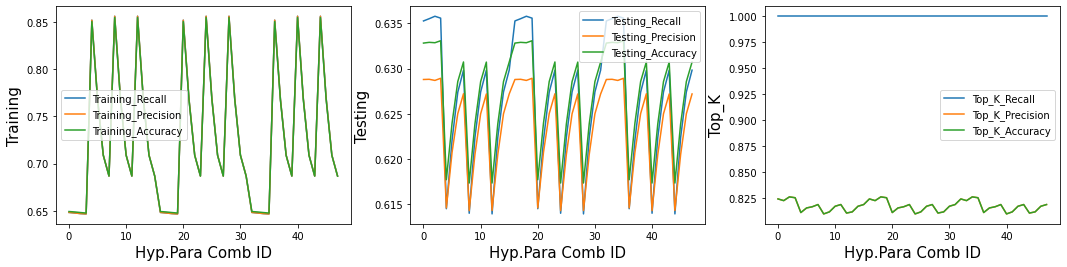

In [11]:
n_cols=3
n_rows=1
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0]
ax.plot(Output["Overall_Training_Recall"],label='Training_Recall')
ax.plot(Output["Overall_Training_Precision"],label='Training_Precision')
ax.plot(Output["Overall_Training_Accuracy"],label='Training_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Training",fontsize=15);

ax = axs[1]
ax.plot(Output["Overall_Testing_Recall"],label='Testing_Recall')
ax.plot(Output["Overall_Testing_Precision"],label='Testing_Precision')
ax.plot(Output["Overall_Testing_Accuracy"],label='Testing_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Testing",fontsize=15);

ax = axs[2]
ax.plot(Output["Top_K_Recall"],label='Top_K_Recall')
ax.plot(Output["Top_K_Precision"],label='Top_K_Precision')
ax.plot(Output["Top_K_Accuracy"],label='Top_K_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Top_K",fontsize=15);



In [12]:
for i in range (len(Output["Overall_Testing_Accuracy"])):
    print("=========================================",i,"==================================================")
    print("TeA=",Output["Overall_Testing_Accuracy"][i],"TeP=",Output["Overall_Testing_Precision"][i],
          "TeR=",Output["Overall_Testing_Recall"][i])
    print("KA=",Output["Top_K_Accuracy"][i],"KP=",Output["Top_K_Precision"][i],
          "KR=",Output["Top_K_Recall"][i])
    print(Output["Classifier"][i])
   

========================================= 0 ==================================================
TeA= 0.63281085987077 TeP= 0.628791627466795 TeR= 0.6352557659672876
KA= 0.824262295081967 KP= 0.824262295081967 KR= 1.0
XGBClassifier(learning_rate=0.01, max_depth=50, min_child_weight=30,
              random_state=1)
========================================= 1 ==================================================
TeA= 0.6328927898334661 TeP= 0.628813502357727 TeR= 0.635503203799632
KA= 0.8226229508196721 KP= 0.8226229508196721 KR= 1.0
XGBClassifier(learning_rate=0.01, max_depth=50, min_child_weight=30,
              random_state=1)
========================================= 2 ==================================================
TeA= 0.6328506746074837 TeP= 0.6286883026408885 TeR= 0.6357738887651228
KA= 0.8262295081967215 KP= 0.8262295081967215 KR= 1.0
XGBClassifier(learning_rate=0.01, max_depth=50, min_child_weight=30,
              random_state=1)
========================================= 3 ===